# Capstone Project - Product Recommendation System using Sentiment Analysis
- Abhradeep Chandra Paul
- Prapti Bhakta
- Siniyya yousuf

## Problem Statement
The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis
Building a recommendation system
Improving the recommendations using the sentiment analysis model
Deploying the end-to-end project with a user interface

In [1]:
# ----------------------------------------
# Core Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ----------------------------------------
# NLTK Setup and Text pre_processing
# ----------------------------------------
import nltk
import ssl
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Handle SSL issue with nltk downloads (some environments require this)
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


# ----------------------------------------
# Scikit-learn and Model Building
# ----------------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances

# ----------------------------------------
# Imbalanced Data Handling
# ----------------------------------------
from imblearn.over_sampling import SMOTE

# ----------------------------------------
# XGBoost (Gradient Boosting)
# ----------------------------------------
import xgboost as xgb

# ----------------------------------------
# Visualization and NLP Utilities
# ----------------------------------------
from wordcloud import WordCloud

# ----------------------------------------
# Model Persistence
# ----------------------------------------
import joblib


In [2]:
# ------------------------------
# Missing Value Utilities
# ------------------------------

# Print percentage of missing values for each column
def print_missing_val_percent_in_cols(sbpr_df):
    for col in sbpr_df.columns:
        missing_percent = sbpr_df[col].isnull().sum() / sbpr_df.shape[0] * 100
        print(f'{col}: {round(missing_percent, 2)}%')

# Return a list of columns with missing values
def find_missing_val_cols(sbpr_df):
    return [col for col in sbpr_df.columns if sbpr_df[col].isnull().sum() > 0]

# Return a list of columns containing a specific substring
def get_cols(sbpr_df, x):
    return [col for col in sbpr_df.columns if x in col]

# Return columns with missing values (excluding ones containing 'num_of_days')
def get_data_missing_cols(sbpr_df):
    data_missing_cols = []
    for col in sbpr_df.columns:
        if sbpr_df[col].isnull().sum() > 0 and 'num_of_days' not in col:
            data_missing_cols.append(col)
            print(f'{col}: {round(sbpr_df[col].isnull().sum() / len(sbpr_df) * 100, 2)}%')
    return data_missing_cols

# ------------------------------
# Feature Overview Utilities
# ------------------------------

# Divide columns into groups based on unique value count
def divide_columns_based_on_number_of_unique_values(sbpr_df, num_unique_vals):
    col_large_unique = []
    col_small_unique = []
    for col in sbpr_df:
        if len(sbpr_df[col].unique()) > num_unique_vals:
            col_large_unique.append(col)
        else:
            col_small_unique.append(col)

    print(f'More than {num_unique_vals} unique values:\n{col_large_unique} (Total: {len(col_large_unique)})\n')
    print(f'Less than {num_unique_vals} unique values:\n{col_small_unique} (Total: {len(col_small_unique)})\n')
    
    return col_large_unique, col_small_unique

# Plot count and pie chart for categorical/low-cardinality columns
def plot_small(sbpr_df, column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.countplot(x=column, data=sbpr_df, ax=ax1)
    sbpr_df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax2)
    plt.suptitle(f"{column} [dtype: {sbpr_df[column].dtype}]")
    plt.savefig(f"{column}.png")
    plt.show()
    print(sbpr_df[column].value_counts().to_string())

# Plot histogram, KDE, and boxplot for numerical/high-cardinality columns
def plot_large(sbpr_df, column):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f"{column} [dtype: {sbpr_df[column].dtype}]")
    try:
        sns.histplot(sbpr_df[column], bins=50, ax=ax1)
        ax1.set_xticks(ax1.get_xticks())
        ax1.tick_params(axis='x', rotation=90)
    except: pass
    try: sns.kdeplot(x=column, data=sbpr_df, ax=ax2)
    except: pass
    try: sns.boxplot(x=column, data=sbpr_df, ax=ax3)
    except: pass
    plt.show()
    print(sbpr_df[column].describe().to_string())
    print()

# ------------------------------
# Model Evaluation Utilities
# ------------------------------

model_scores_dict = {}

# Calculate and return key classification metrics
def classification_metrics(y_actual, y_pred, model_name_key=None):
    confusion_mat = metrics.confusion_matrix(y_actual, y_pred)
    TP, TN = confusion_mat[1,1], confusion_mat[0,0]
    FP, FN = confusion_mat[0,1], confusion_mat[1,0]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy   = metrics.accuracy_score(y_actual, y_pred)
    precision  = metrics.precision_score(y_actual, y_pred)
    recall     = metrics.recall_score(y_actual, y_pred)
    TPR, FNR, FPR = sensitivity, FN / (TP + FN), FP / (FP + TN)
    f1 = metrics.f1_score(y_actual, y_pred)

    clf_data = [[sensitivity, specificity, accuracy, precision, recall, TPR, FNR, FPR, f1]]
    clf_sbpr_df = pd.DataFrame(clf_data, columns=[
        'sensitivity', 'specificity', 'accuracy', 'precision', 'recall', 
        'TPR', 'FNR', 'FPR', 'F1_score'
    ])
    clf_sbpr_df = round(clf_sbpr_df, 2)

    if model_name_key:
        model_scores_dict[model_name_key] = np.round(np.array(clf_data[0]), 2)

    return clf_sbpr_df

# Plot ROC curve
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Create a DataFrame with predictions for different probability thresholds
def generate_prob_threshold_sbpr_df(y_actual, y_pred_prob, thresholds):
    y_pred_prob = y_pred_prob[:, 1]
    threshold_sbpr_df = pd.DataFrame({'Actual Churn': y_actual, 'Probability': y_pred_prob})
    
    for i in thresholds:
        threshold_sbpr_df[i] = [1 if p >= i else 0 for p in y_pred_prob]
    
    return threshold_sbpr_df

# Generate accuracy, sensitivity, and specificity for each threshold
def generate_optimal_cutoff_sbpr_df(threshold_sbpr_df, thresholds):
    cutoff_sbpr_df = pd.DataFrame(columns=['prob', 'accuracy', 'sensi', 'speci'])

    for i in thresholds:
        cm = metrics.confusion_matrix(threshold_sbpr_df['Actual Churn'], threshold_sbpr_df[i])
        total = cm.sum()
        accuracy = (cm[0,0] + cm[1,1]) / total
        speci = cm[0,0] / (cm[0,0] + cm[0,1])
        sensi = cm[1,1] / (cm[1,0] + cm[1,1])
        cutoff_sbpr_df.loc[i] = [i, accuracy, sensi, speci]
    
    return cutoff_sbpr_df

# Evaluate classification metrics over multiple thresholds
def metrics_on_different_thresholds(y_actual, thresholds, threshold_sbpr_df):
    joined_sbpr_df = pd.DataFrame(columns=[
        'sensitivity', 'specificity', 'accuracy', 'precision', 
        'recall', 'TPR', 'FNR', 'FPR', 'F1_score'
    ])
    for i in thresholds:
        row = classification_metrics(y_actual, threshold_sbpr_df[i])
        joined_sbpr_df = pd.concat([joined_sbpr_df, row], ignore_index=True)
    
    joined_sbpr_df.index = thresholds
    return joined_sbpr_df


In [3]:
# Load the dataset from a CSV file named 'sample30.csv' into a DataFrame
sbpr_df = pd.read_csv('sample30.csv')


In [4]:
print("Data loaded successfully. Shape:", sbpr_df.shape)
sbpr_df.head()  # Displays the first 5 rows


Data loaded successfully. Shape: (30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [5]:
# Display concise summary of the DataFrame, including number of non-null entries and data types for each column
sbpr_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
# Show the total number of missing (null) values in each column of the DataFrame
sbpr_df.isnull().sum()


id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [7]:
# Display the count of each unique value (e.g., 1 for purchased, 0 for not) in the 'reviews_didPurchase' column
sbpr_df.reviews_didPurchase.value_counts()


reviews_didPurchase
False    14498
True      1434
Name: count, dtype: int64

In [8]:
# This line provides summary statistics for each numerical column in the DataFrame.
# It includes metrics like count, mean, standard deviation, min, 25th percentile, median (50%), 75th percentile, and max.
# This is useful for understanding the distribution and spread of the data.
sbpr_df.describe()


,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
# This line counts the number of occurrences of each unique value in the 'id' column.
# It's typically used to identify duplicate IDs or to check how frequently each ID appears in the dataset.
# Useful for detecting if there are repeated entries for a product/user/etc.
sbpr_df['id'].value_counts()


id
AVpf3VOfilAPnD_xjpun    8545
AVpfPaoqLJeJML435Xk9    3325
AVpfJP1C1cnluZ0-e3Xy    2039
AVpfW8y_LJeJML437ySW    1186
AVpfRTh1ilAPnD_xYic2    1143
                        ... 
AVpfP-rELJeJML435jEN       1
AVpfbpzd1cnluZ0-kqJV       1
AVpfbjraLJeJML439F91       1
AVpfa1joLJeJML4385hb       1
AV13O1A8GV-KLJ3akUyj       1
Name: count, Length: 271, dtype: int64

In [10]:
# This line counts the number of occurrences of each unique value in the 'id' column.
# It's typically used to identify duplicate IDs or to check how frequently each ID appears in the dataset.
# Useful for detecting if there are repeated entries for a product/user/etc.
sbpr_df['id'].value_counts()


id
AVpf3VOfilAPnD_xjpun    8545
AVpfPaoqLJeJML435Xk9    3325
AVpfJP1C1cnluZ0-e3Xy    2039
AVpfW8y_LJeJML437ySW    1186
AVpfRTh1ilAPnD_xYic2    1143
                        ... 
AVpfP-rELJeJML435jEN       1
AVpfbpzd1cnluZ0-kqJV       1
AVpfbjraLJeJML439F91       1
AVpfa1joLJeJML4385hb       1
AV13O1A8GV-KLJ3akUyj       1
Name: count, Length: 271, dtype: int64

In [11]:
# This line returns the number of unique values in each column of the DataFrame.
# It's helpful for understanding the variability or uniqueness of values per column.

sbpr_df.nunique()


id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [12]:
# This line counts the occurrences of each unique value in the 'user_sentiment' column.
# It helps to understand how many reviews are positive, negative, or possibly neutral (if applicable).
# Useful for sentiment analysis or building sentiment-based recommendation features.
sbpr_df['user_sentiment'].value_counts()


user_sentiment
Positive    26632
Negative     3367
Name: count, dtype: int64

In [13]:
# This line returns the total number of missing (null/NaN) values in each column of the DataFrame `sbpr_df`.
# It's useful to assess data quality and decide whether to impute, drop, or handle missing values in some other way.
sbpr_df.isnull().sum()


id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [14]:
# This line filters and displays the first few rows (default = 5) where the 'manufacturer' column has missing (null) values.
# It's useful for inspecting what kind of data is missing and identifying patterns or potential fixes.
sbpr_df[sbpr_df['manufacturer'].isnull()].head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
22210,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-03-05T00:00:00.000Z,NaN,False,1,I have read the entire Alex Cross series and I...,Disappointing casting,NaN,NaN,poorcrossing,Negative
22211,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-10-11T00:00:00.000Z,NaN,False,1,Idris Elba was originally cast in the lead rol...,Atrocious casting,NaN,NaN,naberios,Positive
22212,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2017-06-11T00:00:00.000Z,NaN,False,2,I was way more excited or this movie than I sh...,Meh,NaN,NaN,jz30,Positive
22213,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2014-12-27T00:00:00.000Z,NaN,False,2,I'm a huge fan of James Patterson and although...,Disappointing Movie,NaN,NaN,david,Positive
22214,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2015-12-26T20:30:31.000Z,NaN,True,3,"not as exciting as the book, but very good",Alex Cross Dvd,NaN,NaN,bobc,Positive


### Null Value Analysis

In [16]:
# This line calculates the percentage of missing values for each column in the DataFrame `sbpr_df`.
# Step-by-step explanation:
# - isnull(): identifies missing values (NaN) in each column
# - mean(): calculates the proportion of missing values in each column (i.e., mean of True/False)
# - round(4): rounds the proportions to 4 decimal places
# - mul(100): converts the proportions to percentages
# - sort_values(ascending=False): sorts the columns by missing percentage in descending order

sbpr_df.isnull().mean().round(4).mul(100).sort_values(ascending=False)


reviews_userProvince    99.43
reviews_userCity        93.57
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_title            0.63
manufacturer             0.47
reviews_username         0.21
reviews_date             0.15
id                       0.00
brand                    0.00
categories               0.00
name                     0.00
reviews_rating           0.00
reviews_text             0.00
user_sentiment           0.00
dtype: float64

In [17]:
# This line filters and displays the first 2 rows where the 'reviews_username' column has missing (NaN) values.
# It's useful for inspecting what other data is present when usernames are missing.

sbpr_df[sbpr_df['reviews_username'].isnull()].head(2)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
1453,AVpe_N91LJeJML43z4jD,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-07-08T00:00:00Z,NaN,NaN,4,"We like this shelf, and found it relatively ea...",Way Basics 3-Shelf Storage Unit in Espresso Wo...,NaN,NaN,NaN,Positive
1531,AVpe_y-I1cnluZ0-bmvh,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2011-10-30T05:00:00Z,NaN,NaN,5,I'm very sensitive to fragrance - most give me...,Wonderful,NaN,NaN,NaN,Positive


##### Insights:
- reviews_userProvince and reviews_userCity have over 90% missing values, making them unsuitable for meaningful analysis.
- Decision: Drop these columns as they contain insufficient usable data.

- reviews_didPurchase has approximately 47% missing values, which can reduce data quality and introduce bias.
- Decision: Drop this column for now due to the high proportion of missing data. It can be reconsidered later if necessary.

In [19]:
# Dropping columns with high percentage of missing values:
# 'reviews_userProvince' and 'reviews_userCity' have over 90% missing values.
# 'reviews_didPurchase' has around 47% missing values, so it's also dropped for now.
sbpr_df.drop(['reviews_didPurchase', 'reviews_userProvince', 'reviews_userCity'], axis=1, inplace=True)


In [20]:
# Calculating percentage of missing values in each column:
# - `isnull().mean()` gives the fraction of missing values.
# - `round(4)` rounds them to 4 decimal places.
# - `mul(100)` converts the fraction to percentage.
# - `sort_values(ascending=False)` sorts the result by highest missing percentage first.
sbpr_df.isnull().mean().round(4).mul(100).sort_values(ascending=False)


reviews_doRecommend    8.57
reviews_title          0.63
manufacturer           0.47
reviews_username       0.21
reviews_date           0.15
id                     0.00
brand                  0.00
categories             0.00
name                   0.00
reviews_rating         0.00
reviews_text           0.00
user_sentiment         0.00
dtype: float64

In [21]:
# Filter the dataframe to find rows where the 'reviews_title' column has null values
# This is useful for identifying products or entries that are missing review titles
null_reviews_title = sbpr_df[sbpr_df['reviews_title'].isnull()]

# Display the first 5 rows of the dataframe where 'reviews_title' is null
# This gives a quick overview of the entries with missing review titles
null_reviews_title.head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
1239,AV1YneDPglJLPUi8IJyQ,Finish,"Household Essentials,Cleaning Supplies,Dish De...",Reckitt Benckiser,"Finish Quantum Dishwasher Detergent, Lemon Spa...",2017-11-16T08:12:30.000Z,True,5,Great quality and a great price,NaN,queen 79,Positive
1441,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2013-11-07T00:00:00Z,NaN,3,Wanted to love this but it's a bit too heavy f...,NaN,julie,Positive
1442,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2015-02-09T00:00:00Z,NaN,3,I have thick coarse hair and for me this just ...,NaN,lisa,Negative
1443,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2013-11-07T00:00:00Z,NaN,3,Wanted to love this but it's a bit too heavy f...,NaN,julie,Positive
1444,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2017-11-27T18:18:38.000Z,True,4,I actually really enjoy this conditioner. Have...,NaN,aland,Positive


In [22]:
# Filter the dataframe to find rows where the 'reviews_title' column is NOT null
# This will return entries that have a valid review title (not missing)
sbpr_df[~sbpr_df['reviews_title'].isnull()].head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [23]:
# Filter the dataframe to find rows where the 'id' column matches a specific value
# In this case, it looks for rows where the 'id' is 'AV16khLE-jtxr-f38VFn'
sbpr_df[sbpr_df['id'] == 'AV16khLE-jtxr-f38VFn']


,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,1,Bought this earlier today and was excited to c...,Disappointing,raeanne,Negative
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,1,I bought this product for my husband and I to ...,Not happy at all,kimmie,Negative
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-28T00:00:00.000Z,False,1,My husband and I bought this for some extra fu...,Very disappointing,cassie,Negative
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,1,Got as a surprise for my husband there is noth...,Don't buy,moore222,Positive
10,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,1,tried it with my husband and felt no different...,pretty dissapoitned,jds1992,Negative
11,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-05T00:00:00.000Z,False,1,Purchased this thinking it would have some sor...,Waste of Money,bre234,Positive
12,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,1,"Bought this to enhance our time a bit, did abs...",waste of money,jds1992,Negative


##### Insights:
- The 'ID' column doesn't appear to provide much value, so it will be removed.

- It seems to serve as a unique identifier for product names, but we’ll use the 'product name' column instead, as it offers a more descriptive label.

In [25]:
# Drop the 'id' column from the dataframe as it is not useful for analysis
sbpr_df.drop('id', axis=1, inplace=True)


In [26]:
# Display the first two rows of the DataFrame to inspect the data after dropping the 'id' column
sbpr_df.head(2)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive


In [27]:
# Get the review text for the product at index 4 in the DataFrame
sbpr_df.loc[4]['reviews_text']


"My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel."

In [28]:
# Get the entire row (all column values) for the product at index 4 in the DataFrame
sbpr_df.loc[4]


brand                                                                K-Y
categories             Personal Care,Medicine Cabinet,Lubricant/Sperm...
manufacturer                                                         K-Y
name                                    K-Y Love Sensuality Pleasure Gel
reviews_date                                    2016-12-21T00:00:00.000Z
reviews_doRecommend                                                False
reviews_rating                                                         1
reviews_text           My husband bought this gel for us. The gel cau...
reviews_title                                                 Irritation
reviews_username                                               walker557
user_sentiment                                                  Negative
Name: 4, dtype: object

In [29]:
# Get the review text for the product at index 20 in the DataFrame
sbpr_df.loc[20]['reviews_text']


"I noticed this product on clearance at a store I shop frequently and decided to give it a try. My husband and I LOVE it! We went back and bought every box left! I, like others have mentioned, am not sure what it is supposed to do other than be a lubricant but for that purpose we like it much better than regular KY Jelly (which tends to dry out and disappear for us). This product stays on for awhile and makes for a very pleasurable experience. The only drawback is that we find it to be a bit sticky. After applying it with your hands you're left with a sticky hand and I agree a little goes a long way! I personally have to be very careful with all products due to skin irritation and surprisingly this actually seems to help that. I did NOT receive a sample and never have."

In [30]:
# Get the last 3 rows of the DataFrame to inspect the most recent entries
sbpr_df.tail(3)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
29997,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,True,5,First of all I love the smell of this product....,Hair is so smooth after use,liviasuexo,Positive
29998,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,ktreed95,Positive
29999,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-19T00:00:00.000Z,True,5,I received this product complimentary from inf...,Conditioned into healthy,kcoopxoxo,Positive


In [31]:
# Get the review text for the product at index 29997 in the DataFrame
sbpr_df.loc[29997]['reviews_text']



'First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did receive this product from influenster for testing purposes but all opinions ARE my own! This review was collected as part of a promotion.'

In [32]:
# Get the review text for the product at index 29998 in the DataFrame
sbpr_df.loc[29998]['reviews_text']


"I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my hair is so oily and fine. This does not make my hair feel heavy, and it doesn't get oily during the day! It really is fantastic and plan on buying it in the future! This review was collected as part of a promotion."

In [33]:
# Filter the DataFrame to get rows where the review text mentions that the review was part of a promotion
sbpr_df[sbpr_df['reviews_text'].str.contains('This review was collected as part of a promotion')]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
23,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2017-08-15T00:00:00.000Z,NaN,5,Loved This review was collected as part of a p...,Loved,ashley a,Positive
41,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,...",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-04-05T00:00:00.000Z,NaN,2,"I did receive 1 bottle but when I ordered, it ...",Not the quantity specifed,nyisha m,Negative
68,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-06-05T00:00:00.000Z,True,3,Love it. I can feel the result in few days. I ...,very soft,leni,Positive
69,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-06-01T00:00:00.000Z,True,3,I use this at night for wrinkles on the face. ...,reduces wrinkles,silvereagle,Positive
...,...,...,...,...,...,...,...,...,...,...,...
29994,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-14T00:00:00.000Z,True,5,I got to try this conditioner for free and boy...,"By far, my new favorite conditioner",smartthunny,Positive
29995,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,True,5,I got this conditioner with Influenster to try...,Softness!!,laurasnchz,Positive
29997,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,True,5,First of all I love the smell of this product....,Hair is so smooth after use,liviasuexo,Positive
29998,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,ktreed95,Positive


In [34]:
# Retrieve the review text from the 41st row (index 41) of the sbpr_df DataFrame
sbpr_df.loc[41]['reviews_text']


'I did receive 1 bottle but when I ordered, it said a pack of 6. I was disappointed about that. This review was collected as part of a promotion.'

In [35]:
# Display the shape of the DataFrame
# The shape attribute returns a tuple representing the number of rows and columns in the DataFrame.
# It helps to understand the size of the dataset.
sbpr_df.shape


(30000, 11)

#### Missing Review Titles
After examining a few review texts and their corresponding titles, it's apparent that many titles contain just parts of the review text or simply complement it.

For further analysis, two options could be considered:

Drop the review title column entirely.

Merge the review title and review text into a single column for more context.

##### Insights:
I lean towards removing the title column as it contains redundant information that doesn't add significant value for further analysis.

In [37]:
# Drop the 'reviews_title' column as it contains redundant information, 
# since the review titles often repeat or complement the review text.
sbpr_df.drop('reviews_title', axis=1, inplace=True)


In [38]:
# Display the first 2 rows of the DataFrame to inspect the data after removing the 'reviews_title' column
sbpr_df.head(2)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive


In [39]:
# Check the number of missing (null) values in each column of the DataFrame
sbpr_df.isnull().sum()


brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_username         63
user_sentiment            1
dtype: int64

In [40]:
# Filter the DataFrame to find rows where 'user_sentiment' is null
sbpr_df[sbpr_df['user_sentiment'].isnull()]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,True,5,my kids absolutely loved this film so much tha...,7.87E+11,NaN


In [41]:
sbpr_df.loc[28354]['reviews_text']  # Access the 'reviews_text' column from the row with index 28354


'my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy'

In [42]:
sbpr_df['reviews_username'].nunique()  # Count the number of unique usernames in the 'reviews_username' column


24914

In [43]:
sbpr_df['reviews_username'].head()  # Display the first 5 usernames from the 'reviews_username' column


0       joshua
1    dorothy w
2    dorothy w
3      rebecca
4    walker557
Name: reviews_username, dtype: object

In [44]:
sbpr_df['reviews_username'].tail()  # Display the last 5 usernames from the 'reviews_username' column


29995       laurasnchz
29996    scarlepadilla
29997       liviasuexo
29998         ktreed95
29999        kcoopxoxo
Name: reviews_username, dtype: object

In [45]:
sbpr_df[sbpr_df['reviews_username'] == '7.87E+11']  # Filter rows where the 'reviews_username' is exactly '7.87E+11'


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
27254,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-01-17T00:00:00.000Z,False,3,I watched the movie from beginning to end. It ...,7.87E+11,Positive
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,True,5,my kids absolutely loved this film so much tha...,7.87E+11,NaN


##### Insights:
- The username '7.87E+11' looks unusual — more like a number than a typical username — but I’ll leave it as is for now.

- Also, it appears there are duplicate records in the dataset, so I’ll proceed to clean those up.

### Removing Duplicates

In [48]:
sbpr_df[sbpr_df.duplicated()].shape  # Get the shape (rows, columns) of duplicated rows in the DataFrame


(52, 10)

In [49]:
sbpr_df[sbpr_df.duplicated(keep=False)].head(4)  # Display the first 4 rows that are duplicates, including all occurrences (not just the first)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
67,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
90,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
1281,Meguiars,"Home,Home Improvement,Automotive,Car Cleaning,...",Parts,Meguiar's Deep Crystal Car Wash 64-Oz.,2017-02-16T21:47:38.000Z,True,5,Meguiar's Deep Crystal Car Wash 64-oz. is top ...,synoptic 12,Positive
1282,Meguiars,"Home,Home Improvement,Automotive,Car Cleaning,...",Parts,Meguiar's Deep Crystal Car Wash 64-Oz.,2017-02-16T21:47:38.000Z,True,5,Meguiar's Deep Crystal Car Wash 64-oz. is top ...,synoptic 12,Positive


In [50]:
sbpr_df[sbpr_df['reviews_username'] == 'mylifeinheels']  # Filter and display all rows where the username is 'mylifeinheels'


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
67,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
79,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T00:00:00.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
90,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive


In [51]:
sbpr_df.drop_duplicates(keep='first', inplace=True)  # Remove duplicate rows, keeping the first occurrence and updating the DataFrame in place


In [52]:
sbpr_df.shape

(29948, 10)

##### Insights
- Making sure we have kept one of the duplicates in above operation


In [54]:
sbpr_df[sbpr_df['reviews_username'] == 'mylifeinheels']  # Display rows with the username 'mylifeinheels' after duplicates have been removed


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
67,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
79,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T00:00:00.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive


In [55]:
sbpr_df.loc[67]['reviews_text']  # Access the 'reviews_text' column from the row with index 67


'Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks'

In [56]:
sbpr_df.loc[79]['reviews_text']  # Access the 'reviews_text' column from the row with index 79


'Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks'

In [57]:
sbpr_df.loc[67]['reviews_text'] == sbpr_df.loc[79]['reviews_text']  # Check if the review texts at index 67 and 79 are exactly the same


True

##### Insights
- Looks like there are duplicate reviews made on different times as well.

In [59]:
sbpr_df.duplicated(subset=['reviews_text', 'reviews_username', 'name']).sum()  # Count the number of duplicate rows based on 'reviews_text', 'reviews_username', and 'name' columns


1743

In [60]:
# Find and display all duplicate rows based on a combination of key columns:
# 'reviews_text', 'reviews_username', 'name', 'brand', 'categories', and 'reviews_date'
# The keep=False option ensures all instances of the duplicates are shown (not just after the first)
sbpr_df[sbpr_df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'], keep=False)]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
4143,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-10-01T00:00:00.000Z,False,1,Loved this machine until I replaced my worn ou...,tired arms,Positive
4151,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-10-01T00:00:00.000Z,NaN,1,Loved this machine until I replaced my worn ou...,tired arms,Positive
15026,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-12T00:00:00.000Z,NaN,3,I use indexes as I prepare various notebooks f...,peterwatts,Positive
15027,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-12T00:00:00.000Z,False,3,I use indexes as I prepare various notebooks f...,peterwatts,Positive
15076,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2011-12-05T00:00:00.000Z,NaN,5,These dividers are essential wherever extra di...,gellis,Positive
15130,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2016-06-15T00:00:00.000Z,NaN,5,I wish that an extra table of content sheet wa...,dave,Negative
15131,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2016-06-15T00:00:00.000Z,True,5,I wish that an extra table of content sheet wa...,dave,Negative
15198,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2011-12-05T00:00:00.000Z,False,5,These dividers are essential wherever extra di...,gellis,Positive
18577,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,False,1,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive
20483,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,True,5,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive


##### Insights
- There are instances where duplicate reviews exist with differing values for the reviews_doRecommend field — one being a valid entry and the other NaN.

- In such cases, the entry with the NaN value in reviews_doRecommend should be removed to retain the more informative record.

In [62]:
# Filter rows that are duplicates based on key columns and also have a NaN value in 'reviews_doRecommend'
# This helps identify duplicate reviews where one version lacks a recommendation value
sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'],
        keep=False
    ) & sbpr_df['reviews_doRecommend'].isnull()
]

     

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
4151,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-10-01T00:00:00.000Z,NaN,1,Loved this machine until I replaced my worn ou...,tired arms,Positive
15026,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-12T00:00:00.000Z,NaN,3,I use indexes as I prepare various notebooks f...,peterwatts,Positive
15076,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2011-12-05T00:00:00.000Z,NaN,5,These dividers are essential wherever extra di...,gellis,Positive
15130,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2016-06-15T00:00:00.000Z,NaN,5,I wish that an extra table of content sheet wa...,dave,Negative


In [63]:
# Drop rows that are duplicates based on selected columns and have a NaN value in 'reviews_doRecommend'
# This retains the informative duplicate(s) and removes those missing recommendation info
sbpr_df.drop(
    sbpr_df[
        sbpr_df.duplicated(
            subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'],
            keep=False
        ) & sbpr_df['reviews_doRecommend'].isnull()
    ].index,
    inplace=True
)


In [64]:
# View a small slice of the DataFrame to inspect rows from index 4150 to 4153
# Useful for checking data after cleaning or verifying specific entries
sbpr_df.loc[4150:4153]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
4150,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2010-05-30T00:00:00.000Z,NaN,1,Impossible to push on freize carpet with moder...,vic,Positive
4152,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-09-16T00:00:00.000Z,NaN,1,On sale because you cannot push it in plush ca...,NaN,Negative
4153,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2013-06-06T14:21:58.000Z,NaN,2,"I bought this vaccum on 5-1-11, it worked fine...",jessrn,Positive


In [65]:
# Identify all rows that are duplicates based on the specified combination of columns:
# 'reviews_text', 'reviews_username', 'name', 'brand', 'categories', and 'reviews_date'
# The keep=False option includes all duplicate occurrences (not just after the first)
sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'],
        keep=False
    )
]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
18577,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,False,1,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive
20483,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,True,5,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive


In [66]:
# Access the 'reviews_text' field from the row with index 18577
sbpr_df.loc[18577].reviews_text


'I purchaed 12443842 for 3.28 and 25483701 for 6.37 - the formulas are exactly the same but the prices are drastically different! http://www.walmart.com/ip/Clorox-Disinfecting-Bathroom-Cleaner-30-Fl-Oz/12443842 http://www.walmart.com/ip/Clorox-Company-COX16930-Clorox-Disinfecting-Bathroom-Cleaner-30-oz/25483701 each bottle reads: Ative Ingredients: n-Alkyl (60 C14, 30 C16, 5 C12, 5 C18) 0.1375 dimethylbenzyl ammonium chloride n-Alkyl (68 C12, 32 C14) 0.1375 dimethyl ethlbenzyl ammonium choride 99.7250 other ingredients 100.0000 total'

##### Insights
- In this case, the customer appears to be dissatisfied due to a pricing discrepancy.

- I will retain the version of the review with the lower rating, as it better reflects the user's negative experience.

In [68]:
# Drop the row with index 20483 from the DataFrame
# Useful when manually removing a specific duplicate or unwanted entry
sbpr_df.drop(20483, inplace=True)


In [69]:
# Identify and display all rows that are duplicated based on a combination of key columns:
# 'reviews_text', 'reviews_username', 'name', 'brand', 'categories', and 'reviews_date'
# keep=False ensures all duplicate instances are shown, not just the later ones
sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'],
        keep=False
    )
]



     

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment


In [70]:
# Get the shape (number of rows and columns) of all rows that are duplicates 
# based on 'reviews_text', 'reviews_username', 'name', 'brand', 'categories', and 'manufacturer'
# keep=False ensures that all instances of duplicates are counted
sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer'],
        keep=False
    )
].shape


     

(3474, 10)

In [71]:
# Get the shape (number of rows and columns) of all duplicate rows based on the following columns:
# 'reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer', and 'reviews_doRecommend'
# keep=False includes all occurrences of duplicates, not just those after the first
sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer', 'reviews_doRecommend'],
        keep=False
    )
].shape


(2694, 10)

In [72]:
# Get the shape (rows, columns) of all duplicate rows based on these columns:
# 'reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer',
# 'reviews_doRecommend', and 'reviews_rating'
# keep=False includes all occurrences of duplicates
sbpr_df[
    sbpr_df.duplicated(
        subset=[
            'reviews_text',
            'reviews_username',
            'name',
            'brand',
            'categories',
            'manufacturer',
            'reviews_doRecommend',
            'reviews_rating'
        ],
        keep=False
    )
].shape

     

(2694, 10)

##### Insights
- Some users appear to have updated their ratings and the reviews_doRecommend flag after initially submitting a review.

In [74]:
# Create a new DataFrame 'a' containing all rows that are duplicates based on the following columns:
# 'reviews_text', 'reviews_username', 'name', 'brand', 'categories', and 'manufacturer'
# keep=False ensures all instances of each duplicate group are included
a = sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer'],
        keep=False
    )
]


In [75]:
# Display the shape (number of rows and columns) of the DataFrame 'a'
# This shows how many duplicate entries were captured based on the specified criteria
a.shape


(3474, 10)

In [76]:
# From the duplicate DataFrame 'a', drop duplicates based on the combination of:
# 'reviews_text', 'reviews_username', 'name', and 'reviews_doRecommend'
# keep='last' retains the most recent entry within each duplicate group
b = a.drop_duplicates(
    subset=['reviews_text', 'reviews_username', 'name', 'reviews_doRecommend'],
    keep='last'
)


In [77]:
# Display the shape (number of rows and columns) of the DataFrame 'b'
# This shows how many entries remain after removing selected duplicates from 'a'
b.shape


(2127, 10)

In [78]:
# Count how many rows in DataFrame 'b' have duplicate 'reviews_text' values
# This helps identify if the same review content still appears more than once
b.duplicated(['reviews_text']).sum()


391

In [79]:
# Display the first few rows where the 'reviews_text' value appears more than once in DataFrame 'b'
# keep=False ensures all instances of the duplicate text are shown
b[b.duplicated(['reviews_text'], keep=False)].head()


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
716,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2017-06-20T13:23:45.000Z,NaN,1,I have now purchased two different 23 oz bottl...,disappointedmom,Positive
728,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2017-06-20T00:00:00.000Z,False,1,I have now purchased two different 23 oz bottl...,disappointedmom,Positive
738,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2012-05-18T04:06:51.000Z,NaN,2,This is a great windex product that I came acr...,suri,Positive
742,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2012-05-18T00:00:00.000Z,False,2,This is a great windex product that I came acr...,suri,Positive
1080,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2015-02-14T22:37:15.000Z,NaN,3,I use this because it has very little fragranc...,kittycatty,Negative


In [80]:
b[b.duplicated(['reviews_text'], keep=False) & b['reviews_doRecommend'].isnull()]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
716,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2017-06-20T13:23:45.000Z,NaN,1,I have now purchased two different 23 oz bottl...,disappointedmom,Positive
738,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2012-05-18T04:06:51.000Z,NaN,2,This is a great windex product that I came acr...,suri,Positive
1080,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2015-02-14T22:37:15.000Z,NaN,3,I use this because it has very little fragranc...,kittycatty,Negative
3707,Canada Dry,"Food & Beverage,Beverages,Soda & Pop,Grocery &...","Dr Pepper/Seven Up, Inc",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,2017-07-23T20:48:35.000Z,NaN,4,I love the diet ginger ale and have been buyin...,vypkf0,Positive
4117,The Honest Company,"Household Chemicals,Laundry,Laundry Detergent,...",The Honest Company,The Honest Company Laundry Detergent,2014-06-20T00:00:00Z,NaN,5,I've been using this laundry detergent for a f...,blessedmomma,Positive
...,...,...,...,...,...,...,...,...,...,...
29479,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-02T15:48:27.000Z,NaN,4,"Out of all three, the conditioner was my favor...",tess22,Positive
29532,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-02-01T05:15:31.000Z,NaN,4,I really liked this conditioner. I got this pr...,tania13,Positive
29537,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-31T07:40:17.000Z,NaN,4,This conditioner was great - although it wasn'...,milavalle13,Positive
29549,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-29T20:32:25.000Z,NaN,4,I've been trying this for the past month and i...,rosberryyy,Positive


##### Insights
- Upon further analysis, the remaining differences among duplicate reviews are primarily due to variations in the reviews_doRecommend flag.

- We will retain only those entries where a valid (non-null) value is present for the reviews_doRecommend flag within duplicate groups.

In [82]:
# Find the number of duplicate entries (based on 'reviews_text', 'reviews_username', and 'name')
# where the 'reviews_doRecommend' value is missing (NaN)
# This helps identify non-informative duplicates that can be removed
sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name'],
        keep=False
    ) & sbpr_df['reviews_doRecommend'].isnull()
].shape


(544, 10)

In [83]:
# Drop rows from the DataFrame where:
# 1. There are duplicates based on 'reviews_text', 'reviews_username', and 'name'
# 2. The 'reviews_doRecommend' value is missing (NaN)
# This helps clean up non-informative duplicates while preserving meaningful entries
sbpr_df.drop(
    sbpr_df[
        sbpr_df.duplicated(subset=['reviews_text', 'reviews_username', 'name'], keep=False) &
        sbpr_df['reviews_doRecommend'].isnull()
    ].index,
    inplace=True
)


In [84]:
# Display the current shape (number of rows and columns) of the DataFrame 'sbpr_df'
# Useful to verify how many records remain after cleaning operations
sbpr_df.shape


(29399, 10)

In [85]:
# Get the shape (number of rows and columns) of duplicate rows based on:
# 'reviews_text', 'reviews_username', 'name', 'categories', 'reviews_doRecommend', 
# 'user_sentiment', and 'reviews_date' columns
# This helps identify how many duplicates exist based on these specific fields
sbpr_df[
    sbpr_df.duplicated(
        subset=['reviews_text', 'reviews_username', 'name', 'categories', 'reviews_doRecommend', 'user_sentiment', 'reviews_date']
    )
].shape

     

(0, 10)

##### Insights
- The remaining duplicates are only differentiated by the reviews_date.


- We will retain only one entry from each duplicate group, regardless of the differing date.

In [87]:
# Display the data types of all columns in the DataFrame 'sbpr_df'
# Useful for checking if columns have the expected data types, especially after cleaning or transformations
sbpr_df.dtypes


brand                  object
categories             object
manufacturer           object
name                   object
reviews_date           object
reviews_doRecommend    object
reviews_rating          int64
reviews_text           object
reviews_username       object
user_sentiment         object
dtype: object

#### reviews_date Column Analysis
  Converting the column to datetime:
-  We will convert the reviews_date column to a proper datetime format to ensure consistent and accurate date operations.

  Checking missing value patterns:
-  After conversion, we'll check for any missing values and understand their distribution across the dataset.

In [89]:
# Remove any part of the date after a period (if the 'reviews_date' contains time or other unwanted characters)
# Using '\\.' to escape the dot or raw string (r'...')
sbpr_df['reviews_date'] = sbpr_df['reviews_date'].str.replace(r'\..+', '', regex=True)



In [90]:
# Display the first few values in the 'reviews_date' column to verify the cleaning process
sbpr_df['reviews_date'].head()


0    2012-11-30T06:21:45
1    2017-07-09T00:00:00
2    2017-07-09T00:00:00
3    2016-01-06T00:00:00
4    2016-12-21T00:00:00
Name: reviews_date, dtype: object

In [91]:
# Count the number of missing (NaN) values in the 'reviews_date' column
# This helps to check how many rows still have missing values after cleaning
sbpr_df['reviews_date'].isnull().sum()


46

In [92]:
# Display the top 5 most frequent values in the 'reviews_date' column
# This helps identify the most common dates in the dataset
sbpr_df['reviews_date'].value_counts()[0:5]


reviews_date
2012-01-26T00:00:00    1039
2014-12-03T00:00:00     524
2014-09-19T00:00:00     406
2014-12-05T00:00:00     345
2014-12-04T00:00:00     301
Name: count, dtype: int64

In [93]:
# Display all rows where the 'reviews_date' column has missing (NaN) values
# This helps to inspect the entries that still lack a review date
sbpr_df[sbpr_df['reviews_date'].isnull()]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1536,Alberto VO5,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",High Ridge Brands Co.,Alberto VO5 Salon Series Smooth Plus Sleek Sha...,NaN,NaN,5,FINALLY! Thank you Alberto VO5 .. You finally ...,nikolaos christodoularas,Positive
1784,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,"This is a real guilty pleasure.An inept, stagy...",zotox,Negative
1785,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,While Clambake was certainly not at the top of...,r. riis rriis,Negative
1786,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,I've enjoyed some of Elvis' movies like Viva L...,boomclap bikecub,Positive
1787,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Not one of Elvis's best movies, but it has som...",NaN,Positive
1788,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,There are basically four criteria by which I j...,eric carr-tune night creature,Positive
1789,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Being a low price DVD, you do not really expec...",paul jones,Positive
1790,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,...and I thought the quality was on the poor s...,suzanne m. colter,Positive
1791,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,"Clambake starring Elvis Presley,Shelley Fabare...",dr robert apuzzio,Positive
1792,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,4,"Like every 1966-67 Elvis movie, you have prett...",NaN,Positive


In [94]:
# Filter and display all rows where the 'brand' column is equal to 'Target.com Use Only'
# This helps to examine entries related to this specific brand
sbpr_df[sbpr_df['brand'] == 'Target.com Use Only']


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1437,Target.com Use Only,"Movies, Music & Books,Movies,Drama,African Ame...",Xenon,Black Sister's Revenge (dvd),2016-04-25T04:01:38,True,5,Awesome movie. It was very entertaining. Dont ...,tam123,Positive
1784,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,"This is a real guilty pleasure.An inept, stagy...",zotox,Negative
1785,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,While Clambake was certainly not at the top of...,r. riis rriis,Negative
1786,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,I've enjoyed some of Elvis' movies like Viva L...,boomclap bikecub,Positive
1787,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Not one of Elvis's best movies, but it has som...",NaN,Positive
1788,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,There are basically four criteria by which I j...,eric carr-tune night creature,Positive
1789,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Being a low price DVD, you do not really expec...",paul jones,Positive
1790,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,...and I thought the quality was on the poor s...,suzanne m. colter,Positive
1791,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,"Clambake starring Elvis Presley,Shelley Fabare...",dr robert apuzzio,Positive
1792,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,4,"Like every 1966-67 Elvis movie, you have prett...",NaN,Positive


##### Insights
- There appears to be no identifiable pattern in the missing reviews_date values based on name or brand. This could be due to a random error.


- We will fill the missing values in the reviews_date column with the mode (most frequent value). Since the number of missing values is small, this should not significantly impact the analysis.

In [96]:
# Fill missing values in 'reviews_date' with the most frequent (mode) value and assign back to the column
sbpr_df['reviews_date'] = sbpr_df['reviews_date'].fillna(sbpr_df['reviews_date'].mode()[0])



In [97]:
# Replace the specified string in 'reviews_date' with the most frequent (mode) value
sbpr_df['reviews_date'] = sbpr_df['reviews_date'].str.replace(" hooks slide or swivel into any desired position", sbpr_df['reviews_date'].mode()[0], regex=False)

     

In [98]:
# Fill missing values in 'reviews_date' with the most frequent (mode) value
# Directly assign the result back to the 'reviews_date' column
sbpr_df['reviews_date'] = sbpr_df['reviews_date'].fillna(sbpr_df['reviews_date'].mode()[0])


In [99]:
# Count the number of missing (NaN) values in the 'reviews_date' column
# This helps to verify if there are any remaining missing values after filling
sbpr_df['reviews_date'].isnull().sum()



0

In [100]:
# Display the first 5 rows of the DataFrame to inspect the data after cleaning
sbpr_df.head(5)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,Positive
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00,False,1,I read through the reviews on here before look...,rebecca,Negative
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00,False,1,My husband bought this gel for us. The gel cau...,walker557,Negative


In [101]:
# Display the data types of all columns in the DataFrame
# This helps verify that the columns have the correct data types after cleaning and transformations
sbpr_df.dtypes


brand                  object
categories             object
manufacturer           object
name                   object
reviews_date           object
reviews_doRecommend    object
reviews_rating          int64
reviews_text           object
reviews_username       object
user_sentiment         object
dtype: object

In [102]:
# Access the value in the 'name' column for the row with index 28421
sbpr_df.loc[28421]['name']


'Concept Housewares 36 Natural Wood ceiling mounted pot rack'

In [103]:
# Filter and display all rows where the 'brand' column is equal to 'Concept Housewares'
# This helps to examine entries related to this specific brand
sbpr_df[sbpr_df['brand'] == 'Concept Housewares']


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
28421,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,3,We moved into a home that already had this pot...,hatestandinginlines,Positive
28422,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,5,Just bought one of these racks after first fin...,karenh2008,Positive
28423,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,5,Living in a townhome definitely has it's perks...,hellodanielle,Positive
28424,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,5,My daughter-in-law purchased this and I liked ...,laurel,Positive
28425,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,5,Heavy duty - very durable-looking. Much more t...,janet,Positive
28426,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,5,"I have a large kitchen, but over my stove wher...",cookinmama2002,Positive
28427,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,5,These units are easy to assemble sturdy and of...,projectbound,Positive
28428,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,2012-01-26T00:00:00,True,5,i love the pot rack. it was very easy to put t...,chomie,Positive


##### Insights
- All entries with the brand 'Concept Housewares' seem to have an issue with the reviews_date column.

- It appears that some part of the product description has been mixed into the reviews_date values.


- We will replace these incorrect reviews_date entries with the mode (most frequent) value to clean up the data.

In [105]:
# Display the first few rows of the DataFrame to inspect the data after cleaning or any changes made
sbpr_df.head()


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,Positive
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00,False,1,I read through the reviews on here before look...,rebecca,Negative
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00,False,1,My husband bought this gel for us. The gel cau...,walker557,Negative


In [106]:
# Count the number of missing (NaN) values in each column of the DataFrame
# This helps identify if there are any remaining missing values across all columns
sbpr_df.isnull().sum()


brand                     0
categories                0
manufacturer            141
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            1
dtype: int64

In [107]:
# Display all rows where the 'user_sentiment' column has missing (NaN) values
# This helps to examine entries that still lack sentiment information
sbpr_df[sbpr_df['user_sentiment'].isnull()]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00,True,5,my kids absolutely loved this film so much tha...,7.87E+11,NaN


In [108]:
# Access the value in the 'reviews_text' column for the row with index 28354
sbpr_df.loc[28354].reviews_text


'my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy'

##### Insights
- We will fill the missing values in the user_sentiment column with "positive", based on the review text for those entries.

In [110]:
# Fill the missing sentiment for the row with index 28354 by setting it to 'Positive'
sbpr_df.loc[28354, 'user_sentiment'] = 'Positive'


In [111]:
# Count the number of missing (NaN) values in each column of the DataFrame
# This helps to verify if there are any remaining missing values after filling the 'user_sentiment' column
sbpr_df.isnull().sum()


brand                     0
categories                0
manufacturer            141
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            0
dtype: int64

In [112]:
# Count the occurrences of product names where the 'manufacturer' column is missing (NaN)
# This helps identify which product names are associated with missing manufacturer data
sbpr_df[sbpr_df['manufacturer'].isnull()]['name'].value_counts()


name
Alex Cross (dvdvideo)    141
Name: count, dtype: int64

In [113]:
# Display the first 2 rows where the 'manufacturer' column has missing (NaN) values
# This helps inspect the entries with missing manufacturer information
sbpr_df[sbpr_df['manufacturer'].isnull()].head(2)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
22210,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-03-05T00:00:00,False,1,I have read the entire Alex Cross series and I...,poorcrossing,Negative
22211,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-10-11T00:00:00,False,1,Idris Elba was originally cast in the lead rol...,naberios,Positive


In [114]:
# Count the occurrences of different 'manufacturer' values for rows where the 'brand' is 'Summit Entertainment'
# This helps to analyze how many different manufacturers are associated with the 'Summit Entertainment' brand
sbpr_df[sbpr_df['brand'] == 'Summit Entertainment']['manufacturer'].value_counts()


manufacturer
Summit Entertainment    671
Name: count, dtype: int64

##### Insights
- The missing values in the manufacturer column are for the product 'Alex Cross (dvdvideo)' with the brand 'Summit Entertainment'.
For all other products from 'Summit Entertainment', the manufacturer is consistently 'Summit Entertainment'.


- We will fill the missing manufacturer values for 'Alex Cross (dvdvideo)' with 'Summit Entertainment'.

In [116]:
# Fill missing values in the 'manufacturer' column with 'Summit Entertainment'
# Directly assign the result back to the 'manufacturer' column
sbpr_df['manufacturer'] = sbpr_df['manufacturer'].fillna('Summit Entertainment')



In [117]:
# Count the number of missing (NaN) values in each column of the DataFrame
# This helps verify if there are any remaining missing values after filling the 'manufacturer' column
sbpr_df.isnull().sum()


brand                     0
categories                0
manufacturer              0
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            0
dtype: int64

In [118]:
# Display the first 6 rows where the 'reviews_username' column has missing (NaN) values
# This helps inspect the entries that still lack a username
sbpr_df[sbpr_df['reviews_username'].isnull()].head(6)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1453,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-07-08T00:00:00Z,NaN,4,"We like this shelf, and found it relatively ea...",NaN,Positive
1531,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2011-10-30T05:00:00Z,NaN,5,I'm very sensitive to fragrance - most give me...,NaN,Positive
1532,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2013-07-19T05:00:00Z,NaN,5,Not all shower gels leave their smell after yo...,NaN,Positive
1787,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),2012-01-26T00:00:00,NaN,2,"Not one of Elvis's best movies, but it has som...",NaN,Positive
1792,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),2012-01-26T00:00:00,NaN,4,"Like every 1966-67 Elvis movie, you have prett...",NaN,Positive
1795,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),2012-01-26T00:00:00,NaN,5,I have seen every one of Elvis's movies over a...,NaN,Positive


##### Insights
- dropping duplicate reviews made on different times

In [120]:
# Remove duplicate rows based on the combination of 'reviews_text', 'reviews_username', and 'name'
# This ensures that only unique combinations of these columns remain in the DataFrame
sbpr_df.drop_duplicates(subset=['reviews_text', 'reviews_username', 'name'], inplace=True)


In [121]:
# Display the shape of the DataFrame to see the number of rows and columns after removing duplicates
sbpr_df.shape


(28129, 10)

In [122]:
# Count and display the number of missing (NaN) values in each column
# This helps ensure that no critical columns still have missing data
sbpr_df.isnull().sum()


brand                     0
categories                0
manufacturer              0
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            0
dtype: int64

In [123]:
# Check how many rows have duplicate 'reviews_text' values
# This gives the count of reviews that appear more than once in the DataFrame
sbpr_df[sbpr_df.duplicated(['reviews_text'])].shape


(922, 10)

In [124]:
# Check how many rows have duplicate combinations of 'reviews_text' and 'name'
# This helps identify if the same review text appears for the same product more than once
sbpr_df[sbpr_df.duplicated(['reviews_text', 'name'])].shape


(48, 10)

In [125]:
# Check how many rows have duplicate combinations of 'reviews_text', 'name', 'reviews_rating', and 'reviews_doRecommend'
# This helps identify truly duplicate reviews with matching sentiment and recommendation values
sbpr_df[sbpr_df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'])].shape


(37, 10)

In [126]:
# Display the last 10 rows where the combination of 'reviews_text' and 'name' is duplicated
# Setting keep=False returns all duplicates, not just the later or earlier occurrences
sbpr_df[sbpr_df.duplicated(['reviews_text', 'name'], keep=False)].tail(10)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
26732,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2016-03-11T00:00:00,NaN,5,Great product,byamazon customer,Positive
26735,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2016-01-03T00:00:00,NaN,5,Good product,bydawn,Positive
27530,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2017-06-30T12:44:15,True,5,My two sons and I love this movie! Like it bet...,kokow,Positive
28213,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00,True,5,my kids absolutely loved this film so much tha...,mamad,Positive
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00,True,5,my kids absolutely loved this film so much tha...,7.87E+11,Positive
28362,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2017-06-30T12:44:15,True,5,My two sons and I love this movie! Like it bet...,kokos,Positive
29231,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T00:00:00,True,4,"To start off, I received this product free to ...",kass12,Positive
29350,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-24T00:00:00,True,4,"I use this conditioner, along with the mask an...",magie916,Positive
29471,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T18:32:32,True,4,"To start off, I received this product free to ...",kass1211,Positive
29581,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-24T21:38:37,True,4,"I use this conditioner, along with the mask an...",magieo,Positive


In [127]:
# Display all rows where the combination of 'reviews_text', 'name', 'reviews_rating', and 'reviews_doRecommend' is duplicated
# Setting keep=False returns all instances of the duplicates
sbpr_df[sbpr_df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1130,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2013-06-29T00:00:00,True,5,This is my favorite shampoo. I have fine hair ...,momandteacher,Positive
1160,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2013-06-29T00:00:00,True,5,This is my favorite shampoo. I have fine hair ...,mom and teacher,Positive
1454,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:16:13,NaN,5,This 3-shelf bookcase is perfect for any small...,christine s,Positive
1456,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:00:00Z,NaN,5,This 3-shelf bookcase is perfect for any small...,christines,Positive
3474,Toy Story,"Holiday Shop,Halloween,Halloween Costume Acces...",Disguise,Toy Story Kids' Woody Accessory Kit,2011-01-07T00:39:52,NaN,3,Bought this for my nephew. Although it isnt th...,aprils mommy,Positive
...,...,...,...,...,...,...,...,...,...,...
28362,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2017-06-30T12:44:15,True,5,My two sons and I love this movie! Like it bet...,kokos,Positive
29231,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T00:00:00,True,4,"To start off, I received this product free to ...",kass12,Positive
29350,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-24T00:00:00,True,4,"I use this conditioner, along with the mask an...",magie916,Positive
29471,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T18:32:32,True,4,"To start off, I received this product free to ...",kass1211,Positive


In [726]:
# Filter the DataFrame to select rows where the username is 'mom and teacher'
sbpr_df[sbpr_df['reviews_username'] == 'mom and teacher']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean


In [129]:
# Display rows where the combination of 'reviews_text', 'name', 'reviews_rating', and 'reviews_doRecommend' is duplicated,
# and where 'reviews_doRecommend' is missing (NaN)
# This helps identify duplicate reviews with missing recommendation flags that may need cleaning
sbpr_df[
    sbpr_df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False) &
    sbpr_df['reviews_doRecommend'].isnull()
]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1454,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:16:13,NaN,5,This 3-shelf bookcase is perfect for any small...,christine s,Positive
1456,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:00:00Z,NaN,5,This 3-shelf bookcase is perfect for any small...,christines,Positive
3474,Toy Story,"Holiday Shop,Halloween,Halloween Costume Acces...",Disguise,Toy Story Kids' Woody Accessory Kit,2011-01-07T00:39:52,NaN,3,Bought this for my nephew. Although it isnt th...,aprils mommy,Positive
3475,Toy Story,"Holiday Shop,Halloween,Halloween Costume Acces...",Disguise,Toy Story Kids' Woody Accessory Kit,2011-01-07T00:00:00Z,NaN,3,Bought this for my nephew. Although it isnt th...,aprilsmommy,Positive
17760,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,NaN,Negative
17761,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,mansexy,Negative
18297,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2013-06-16T19:21:26,NaN,3,I believe this is meant for a kids room but I ...,savvy guy,Positive
18298,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2013-06-16T00:00:00Z,NaN,3,I believe this is meant for a kids room but I ...,savvyguy,Positive
18538,Physician's Formula,"Personal Care,Makeup,Concealer & Foundation,Fo...",Physicians Formula,Physicians Formula Mineral Wear Talc-Free Mine...,2011-06-21T00:00:00Z,NaN,5,This powder is perfect for my extremely fair s...,classyshopper,Positive
18542,Physician's Formula,"Personal Care,Makeup,Concealer & Foundation,Fo...",Physicians Formula,Physicians Formula Mineral Wear Talc-Free Mine...,2011-06-21T05:00:00Z,NaN,5,This powder is perfect for my extremely fair s...,classy shopper,Positive


##### Insights
- Some duplicate review texts appear to come from the same person, but the discrepancy in their usernames (due to spaces) causes them to be treated as separate users. For example, 'momandteacher' vs 'mom and teacher'.


- We will create a new column by removing spaces from the usernames and use this column to identify and remove duplicates.nplace=True)


In [131]:
# Create a new column 'reviews_username_no_spaces' by removing spaces from the 'reviews_username' column
sbpr_df['reviews_username_no_spaces'] = sbpr_df['reviews_username'].str.replace(' ', '')


In [132]:
# Display the shape of the DataFrame to check the number of rows and columns
sbpr_df.shape


(28129, 11)

In [133]:
# Check how many rows have duplicates based on the combination of 'reviews_text', 'name', and 'reviews_username_no_spaces'
# This helps to identify duplicate reviews after cleaning the usernames
sbpr_df[sbpr_df.duplicated(['reviews_text', 'name', 'reviews_username_no_spaces'], keep=False)].shape


(18, 11)

In [134]:
# Remove duplicates based on the combination of 'reviews_text', 'name', and 'reviews_username_no_spaces'
# Keep the first occurrence of each unique combination and remove the rest
sbpr_df.drop_duplicates(['reviews_text', 'name', 'reviews_username_no_spaces'], keep='first', inplace=True)



In [135]:

# Display rows where the combination of 'reviews_text', 'name', 'reviews_rating', and 'reviews_doRecommend' is duplicated
# Setting keep=False returns all instances of the duplicates, allowing us to inspect the repeated entries
sbpr_df[sbpr_df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
3607,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,2014-02-06T00:00:00,True,5,"I am 46 years old and I have always had dry, c...",cmd412,Positive,cmd412
3625,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,2014-02-06T00:00:00,True,5,"I am 46 years old and I have always had dry, c...",catchersmom,Positive,catchersmom
6346,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2017-03-03T00:00:00,True,5,Good,patty,Positive,patty
6394,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2016-11-18T00:00:00,True,5,Best chili,edna,Positive,edna
6413,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2016-11-16T00:00:00,True,5,Best chili,none,Positive,none
6439,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2015-09-15T00:00:00,True,5,Good,shopper,Positive,shopper
15441,Chester's,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...",Frito-Lay,Chester's Cheese Flavored Puffcorn Snacks,2016-09-22T00:00:00,True,5,Wonderful,tina,Positive,tina
15474,Chester's,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...",Frito-Lay,Chester's Cheese Flavored Puffcorn Snacks,2016-11-20T00:00:00,True,5,Wonderful,sbogard,Positive,sbogard
15731,Lysol,"Household Chemicals,Household Cleaners,Disinfe...",Reckitt Benckiser,"Lysol Concentrate Deodorizing Cleaner, Origina...",2015-09-10T00:00:00,True,5,Great,tuttyb,Positive,tuttyb
15732,Lysol,"Household Chemicals,Household Cleaners,Disinfe...",Reckitt Benckiser,"Lysol Concentrate Deodorizing Cleaner, Origina...",2015-09-07T00:00:00,True,5,Great,sally,Positive,sally


In [136]:
# Display all rows where the 'reviews_username' is 'none'
# This helps check if any reviews have 'none' as the username, which could be an error or placeholder
sbpr_df[sbpr_df['reviews_username'] == 'none']


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
1039,KIND,"Food,Packaged Foods,Snacks,Cereal Bars and Gra...",Kind Fruit & Nut Bars,Kind Dark Chocolate Chunk Gluten Free Granola ...,2016-11-10T00:00:00,False,3,They're so hard and dry. They fall into a thou...,none,Negative,none
3769,Ragu,"Food,Packaged Foods,Condiments, Dips, & Salad ...",Unilever,Ragu Roasted Garlic Parmesan Pasta Sauce,2016-07-27T00:00:00,True,5,The sauce was very creamy and tasted fresh and...,none,Positive,none
3964,Pendaflex,"School & Office Supplies,Filing,Files,File Fol...",Esselte Corporation,"Pendaflex174 Divide It Up File Folder, Multi S...",2013-01-23T07:00:00,NaN,4,This type of file is handy for receipts and sm...,none,Positive,none
6413,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2016-11-16T00:00:00,True,5,Best chili,none,Positive,none
22820,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2016-11-29T00:00:00,True,5,good value,none,Positive,none
26801,ANCHOR BAY,"Movies, Music & Books,Movies,Exercise & Fitnes...",Starz,Leslie Sansone:Belly Blasting Walk (dvd),2016-05-09T15:13:21,True,4,It keeps you motivated and moving. Its not dif...,none,Positive,none


In [137]:
# Display rows where the combination of 'reviews_text', 'name', 'reviews_rating', and 'reviews_doRecommend' is duplicated,
# and where 'reviews_username' is missing (NaN). 
# This helps identify duplicate reviews that are missing the username, which may require cleaning.
sbpr_df[
    sbpr_df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False) &
    sbpr_df['reviews_username'].isnull()
]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
17760,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,NaN,Negative,NaN
18308,Tramontina,"Kitchen & Dining,Cookware & Bakeware,Pots & Pa...",Tramontina USA Inc.,Tramontina Ceramica 10 Piece Cookware Set - Red,2017-12-25T17:18:32,True,5,I love this cookware. It's non-stick and made ...,NaN,Positive,NaN


In [138]:
# Display the count of 'reviews_username' for rows where the combination of 'reviews_text', 'name', 'reviews_rating', and 'reviews_doRecommend' is duplicated
# This helps identify how many times each username appears among the duplicated reviews
sbpr_df[sbpr_df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)]['reviews_username'].value_counts()


reviews_username
byamazon customer    4
cmd412               1
byhu                 1
roger                1
panther              1
paul                 1
monie                1
byfei611611          1
byflor laos          1
byerica              1
bywang               1
byjessyjin           1
byyangyang           1
catchersmom          1
byemily              1
byming zhong         1
bydawn               1
kokow                1
mamad                1
7.87E+11             1
kokos                1
kass12               1
magie916             1
kass1211             1
strongcipher         1
chilli               1
breevee              1
mvamarillo           1
patty                1
edna                 1
none                 1
shopper              1
tina                 1
sbogard              1
tuttyb               1
sally                1
midi                 1
nelly                1
mansexy              1
sandraskates         1
snugglebutts         1
hockeyzoom           1
peggy            

In [139]:
# Count the number of missing (NaN) values in each column
# This provides an overview of any remaining missing data in the DataFrame
sbpr_df.isnull().sum()


brand                            0
categories                       0
manufacturer                     0
name                             0
reviews_date                     0
reviews_doRecommend           2013
reviews_rating                   0
reviews_text                     0
reviews_username                57
user_sentiment                   0
reviews_username_no_spaces      57
dtype: int64

##### Insights
- Checking if dropping rows with username missing is a viable strategy

In [141]:
# Create a list of unique product names where the 'reviews_username' is missing
# This helps identify which products have missing usernames in their reviews
products_with_missing_username = list(set(sbpr_df[sbpr_df['reviews_username'].isnull()]['name'].to_list()))


In [142]:
# Display the list of products with missing usernames
products_with_missing_username


['Ogx Conditioner, Hydrating Teatree Mint',
 'Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee',
 'Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix',
 'Tramontina Ceramica 10 Piece Cookware Set - Red',
 'Clambake (dvd)',
 'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com',
 'Yes To Carrots Nourishing Body Wash',
 'Clear Scalp & Hair Therapy Total Care Nourishing Shampoo',
 'Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Scooby Doo And The Loch Ness Monster (blu-Ray)',
 'Heiress (dvd)',
 "Toy Story Kids' Woody Accessory Kit",
 'Vaseline Intensive Care Healthy Hands Stronger Nails',
 'Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural',
 'Nexxus Exxtra Gel Style Creation Sculptor']

In [143]:
# For all products that have missing usernames, count how many times each product name appears in the dataset
# This helps understand the frequency of reviews for those specific products
sbpr_df[sbpr_df['name'].isin(products_with_missing_username)]['name'].value_counts()


name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  7841
Nexxus Exxtra Gel Style Creation Sculptor                                                                   458
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com               347
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          266
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo                                                    232
Vaseline Intensive Care Healthy Hands Stronger Nails                                                         95
Yes To Carrots Nourishing Body Wash                                                                          65
Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix                                                    55
Ogx Conditioner, Hydrating Teatree Mint                                                            

In [144]:
# Count how many reviews are missing 'reviews_username' for each product name
# This helps identify which products have anonymous or incomplete review data
sbpr_df[sbpr_df['reviews_username'].isnull()]['name'].value_counts()


name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  20
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com              13
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          7
Clambake (dvd)                                                                                              3
Yes To Carrots Nourishing Body Wash                                                                         2
Heiress (dvd)                                                                                               2
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee     1
Toy Story Kids' Woody Accessory Kit                                                                         1
Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix                                                   1
Tramo

Dropping rows which have same data except for a missing username

In [146]:
# Get a list of review texts where:
# - The combination of ['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'] is duplicated
# - The 'reviews_username' is missing
# This helps identify anonymous reviews that are duplicates

sbpr_df[
    sbpr_df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False) &
    sbpr_df['reviews_username'].isnull()
]['reviews_text'].to_list()


['The Axe Phoenix has a great smell to it but about 20 minutes after applying the scent starts to make you feel sick. Also the product is very clumpy and gritty once you put it on, leaving it hard to wash off in the shower. This is definitely still the little boys or teenagers deodorant. This review was collected as part of a promotion.',
 "I love this cookware. It's non-stick and made in Italy. Be sure to follow the seasoning directions before using and do not use on high heat. You'll be rewarded with easy cooking and cleanup."]

In [147]:
# Display all rows where the review text exactly matches a specific string.
# This is used to identify all duplicates or variations of a particular review for potential cleanup.

sbpr_df[
    sbpr_df['reviews_text'] == 'The Axe Phoenix has a great smell to it but about 20 minutes after applying the scent starts to make you feel sick. Also the product is very clumpy and gritty once you put it on, leaving it hard to wash off in the shower. This is definitely still the little boys or teenagers deodorant. This review was collected as part of a promotion.'
]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
17760,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,NaN,Negative,NaN
17761,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,mansexy,Negative,mansexy


In [148]:
# Dropping the row at index 17760 from the DataFrame.
# Likely done to remove a duplicate or incorrect entry based on earlier inspection.

sbpr_df.drop(17760, inplace=True)


In [149]:
# Filtering the DataFrame to find all rows where the 'reviews_text' matches a specific review.
# This is typically used to identify duplicates or examine all entries with identical review content.

sbpr_df[
    sbpr_df['reviews_text'] == "I love this cookware. It's non-stick and made in Italy. Be sure to follow the seasoning directions before using and do not use on high heat. You'll be rewarded with easy cooking and cleanup."
]


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
18308,Tramontina,"Kitchen & Dining,Cookware & Bakeware,Pots & Pa...",Tramontina USA Inc.,Tramontina Ceramica 10 Piece Cookware Set - Red,2017-12-25T17:18:32,True,5,I love this cookware. It's non-stick and made ...,NaN,Positive,NaN
18309,Tramontina,"Kitchen & Dining,Cookware & Bakeware,Pots & Pa...",Tramontina USA Inc.,Tramontina Ceramica 10 Piece Cookware Set - Red,2017-12-25T17:18:32,True,5,I love this cookware. It's non-stick and made ...,sandraskates,Positive,sandraskates


In [150]:
# Dropping the row at index 18308 from the DataFrame.
# This is likely done to remove a duplicate or incorrectly entered review.

sbpr_df.drop(18308, inplace=True)


In [151]:
# Checking the current shape (number of rows and columns) of the DataFrame 
# after recent cleaning steps like duplicate removal.

sbpr_df.shape


(28118, 11)

In [152]:
# Displaying the number of missing (null) values in each column of the DataFrame.
# This helps ensure data completeness after cleaning steps.

sbpr_df.isnull().sum()


brand                            0
categories                       0
manufacturer                     0
name                             0
reviews_date                     0
reviews_doRecommend           2012
reviews_rating                   0
reviews_text                     0
reviews_username                55
user_sentiment                   0
reviews_username_no_spaces      55
dtype: int64

In [153]:
# Counting the number of missing usernames grouped by product name.
# This helps identify which products have reviews with missing usernames.

sbpr_df[sbpr_df['reviews_username'].isnull()]['name'].value_counts()


name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  20
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com              13
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          7
Clambake (dvd)                                                                                              3
Yes To Carrots Nourishing Body Wash                                                                         2
Heiress (dvd)                                                                                               2
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee     1
Toy Story Kids' Woody Accessory Kit                                                                         1
Scooby Doo And The Loch Ness Monster (blu-Ray)                                                              1
Ogx C

In [154]:
# Filter rows where 'name' is in the list 'products_with_missing_username'
# Then select the 'name' column from those rows
# Finally, count the frequency of each unique name
sbpr_df[sbpr_df['name'].isin(products_with_missing_username)]['name'].value_counts()


name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  7841
Nexxus Exxtra Gel Style Creation Sculptor                                                                   458
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com               347
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          266
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo                                                    232
Vaseline Intensive Care Healthy Hands Stronger Nails                                                         95
Yes To Carrots Nourishing Body Wash                                                                          65
Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix                                                    54
Ogx Conditioner, Hydrating Teatree Mint                                                            

In [155]:
# Check for missing (null) values in each column of the DataFrame
# and return the total count of nulls per column
sbpr_df.isnull().sum()


brand                            0
categories                       0
manufacturer                     0
name                             0
reviews_date                     0
reviews_doRecommend           2012
reviews_rating                   0
reviews_text                     0
reviews_username                55
user_sentiment                   0
reviews_username_no_spaces      55
dtype: int64

##### Insights
- Since the number of missing usernames is low and the products have reviews from other users, we can safely remove these rows from the dataset.

In [157]:
# Drop the 'reviews_username_no_spaces' column from the DataFrame
# axis=1 indicates that we're dropping a column (not a row)
# inplace=True means the change is applied directly to sbpr_df without needing to reassign
sbpr_df.drop('reviews_username_no_spaces', axis=1, inplace=True)


In [158]:
# Identify rows where the 'reviews_username' column has missing (null) values
# Get the index of those rows and drop them from the DataFrame
# inplace=True applies the change directly to sbpr_df
sbpr_df.drop(sbpr_df[sbpr_df['reviews_username'].isnull()].index, inplace=True)


In [159]:
# Display the shape of the DataFrame as a tuple (number of rows, number of columns)
sbpr_df.shape


(28063, 10)

##### Insights
Completing Null Value Analysis

- Eliminated duplicate records through strategic selection and grouping

- Dropped columns with excessive missing data

- Filled in missing values using either business rules or statistical methods, depending on the context



### Anlayzing Sentiment and Ratings

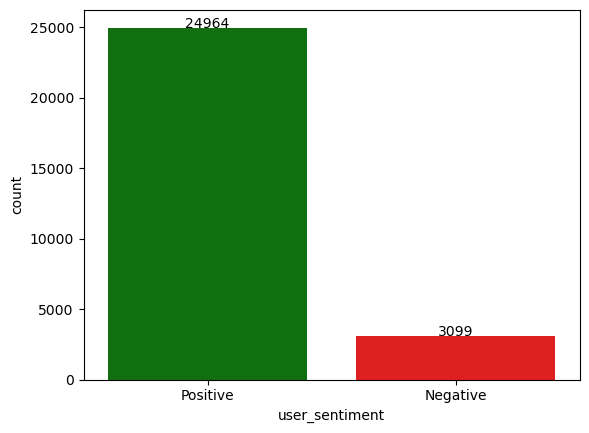

In [162]:
# Define custom colors for each sentiment
custom_palette = {
    'Positive': 'green',
    'Neutral': 'gray',
    'Negative': 'red'
}

# Create the plot
ax = sns.countplot(x='user_sentiment', hue='user_sentiment', data=sbpr_df, palette=custom_palette, legend=False)

# Add count labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,  # x position (center of the bar)
        height + 1,                      # y position (slightly above the bar)
        int(height),                     # text (count value)
        ha="center"                      # horizontal alignment
    )

plt.show()


In [163]:
# Generate descriptive statistics for the 'reviews_rating' column
# Includes count, mean, standard deviation, min, max, and quartile values
sbpr_df['reviews_rating'].describe()


count    28063.000000
mean         4.524427
std          0.931650
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

In [164]:
# Count the number of occurrences for each unique value in the 'reviews_rating' column
sbpr_df['reviews_rating'].value_counts()


reviews_rating
5    19855
4     5556
3     1221
1     1055
2      376
Name: count, dtype: int64

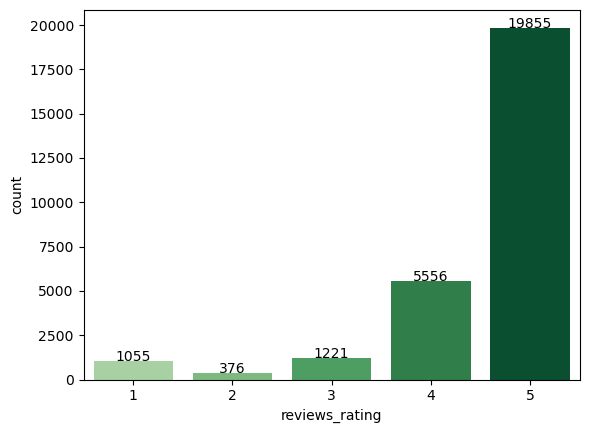

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom shades of green for each rating (assuming ratings are 1–5)
custom_palette = {
    1: '#a1d99b',
    2: '#74c476',
    3: '#41ab5d',
    4: '#238b45',
    5: '#005a32'
}

# Create the count plot using the custom palette
ax = sns.countplot(x='reviews_rating', hue='reviews_rating', data=sbpr_df, palette=custom_palette, legend=False)

# Add count numbers on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,  # Center x
        height + 1,                      # Just above the bar
        int(height),                     # Count value
        ha='center', fontsize=10
    )

plt.show()



##### Insights
- There is a significant class imbalance in both the reviews_rating and user_sentiment columns, with a strong bias toward positive values.


- To address this imbalance during model training, we can apply SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples for underrepresented classes and achieve a more balanced dataset.

In [167]:
# Display the first 2 rows of the DataFrame to preview the data structure and content
sbpr_df.head(2)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive


### Most common brands (Top 10)

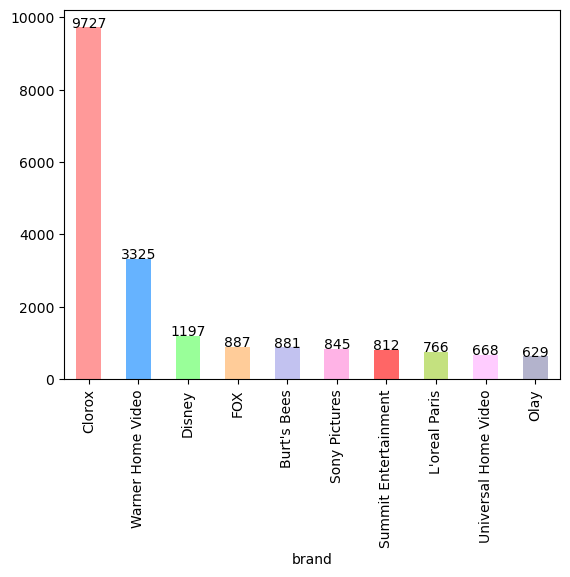

In [169]:
# Get the top 10 most frequent brands from the 'brand' column
# Plot them as a bar chart with different colors for each bar
ax = sbpr_df['brand'].value_counts()[:10].plot(kind='bar', 
                                                color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', 
                                                       '#ffb3e6', '#ff6666', '#c4e17f', '#ffccff', '#b3b3cc'])

# Add count numbers on top of each bar
for p in ax.patches:
    height = p.get_height()  # Get the height of each bar (i.e., the count)
    ax.text(
        p.get_x() + p.get_width() / 2.,  # X position (center of the bar)
        height + 1,                      # Y position (slightly above the bar)
        int(height),                     # Display the count value
        ha='center', fontsize=10         # Horizontal alignment and font size
    )

# Display the plot
plt.show()

In [170]:
# Get the top 10 most common brands from the 'brand' column
# Extract the brand names (index of the value_counts result) and convert them to a list
most_com_brands = sbpr_df['brand'].value_counts()[:10].index.to_list()


In [171]:
# Filter the DataFrame to include only rows where the 'brand' is in the list of most common brands
most_com_brands_sbpr_df = sbpr_df[sbpr_df['brand'].isin(most_com_brands)]


In [172]:
# Display the first few rows (default 5) of the filtered DataFrame 'most_com_brands_sbpr_df'
# to preview the data for the most common brands
most_com_brands_sbpr_df.head()


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
54,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2014-09-01T00:00:00,False,1,I used (and loved) this product for several ye...,alnscoob97,Positive
55,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-02-11T00:00:00,False,1,I have been using Oil of Olay for over 20 year...,star33,Negative
56,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2014-09-07T00:00:00,False,1,I am so disappointed! I have used this product...,jacmary,Positive
57,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2014-07-10T00:00:00,False,1,I've been using this product for years and it ...,mabelle,Negative
58,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2014-04-13T00:00:00,False,1,It took me so long to find a moisturizer that ...,kayc,Positive


### Brands againts ratings

In [174]:
# Create a pivot table to calculate the mean 'reviews_rating' for each 'brand'
# The 'index' is set to 'brand', and the 'values' are set to 'reviews_rating'
# The aggregation function ('aggfunc') is set to 'mean' to get the average rating per brand
# Sort the pivot table by the 'reviews_rating' in descending order
most_com_brands_sbpr_df.pivot_table(
    index='brand',
    values='reviews_rating',
    aggfunc='mean'
).sort_values(by='reviews_rating', ascending=False)  # Optionally, you can uncomment the .plot() line to create a horizontal bar plot


,reviews_rating
brand,
Clorox,4.824406
Olay,4.689984
Disney,4.686717
Sony Pictures,4.674556
Burt's Bees,4.650397
Summit Entertainment,4.584975
Universal Home Video,4.491018
Warner Home Video,4.350677
FOX,4.335964


##### Insights:
Consistently High Ratings:

-  All of the top 10 brands maintain an average rating above 4 stars, indicating that customers are generally satisfied with their products. This suggests that these brands have a strong reputation for quality and customer satisfaction.

Top Performer:

-  Clorox stands out with the highest average rating of 4.82, which may indicate that it is seen as exceptionally reliable or effective by its customers. It could be worthwhile to explore what specific attributes of Clorox's products drive such positive feedback (e.g., product performance, packaging, value).

Brand Consistency:

-   Brands like Olay, Disney, and Sony Pictures have ratings close to 4.7, showing a consistent level of high customer satisfaction. This consistency can be attributed to their well-established market presence and reputation.

Relatively Low Ratings for Some:

-   Brands like L'Oréal Paris (with a rating of 4.23) and FOX (4.33) are among the lowest in the top 10, although still above 4 stars. This suggests there might be areas for improvement in product offerings or customer experience in these brands.

Customer Sentiment:

-   Brands with high ratings likely correlate with positive sentiment in customer reviews. A detailed sentiment analysis could reveal specific emotional drivers behind these ratings, which could be leveraged to improve or maintain customer loyalty.

Product Categories Influence:

-   Brands like Disney and Olay may have more positive ratings due to their broader appeal or better alignment with consumer needs in specific categories (e.g., entertainment, skincare). Products in different categories may experience varying satisfaction levels.

Volume vs. Rating:

-   There may be a correlation between the number of reviews and the average rating. Brands with more reviews might have ratings that fluctuate more, while those with fewer reviews might maintain a consistently high score.


### Sentiment against Ratings

In [176]:
# Count the number of occurrences for each unique value in the 'user_sentiment' column
# This helps to understand the distribution of sentiments in the dataset
sbpr_df['user_sentiment'].value_counts()


user_sentiment
Positive    24964
Negative     3099
Name: count, dtype: int64

In [177]:
# Create a cross-tabulation (contingency table) to show the relationship between 'reviews_rating' and 'user_sentiment'
# The index represents the 'reviews_rating', and the columns represent 'user_sentiment'
# This will give you a matrix showing how different sentiment values correlate with each rating
pd.crosstab(index=sbpr_df['reviews_rating'], columns=sbpr_df['user_sentiment'])


user_sentiment,Negative,Positive
reviews_rating,,
1,459,596
2,131,245
3,206,1015
4,536,5020
5,1767,18088


In [178]:
# Create a pivot table to calculate the average 'reviews_rating' for each 'user_sentiment'
# The 'index' is set to 'user_sentiment', and the 'values' are set to 'reviews_rating'
# This will show the mean rating for each sentiment category
sbpr_df.pivot_table(
    index='user_sentiment',
    values='reviews_rating'
)


,reviews_rating
user_sentiment,
Negative,3.974831
Positive,4.592653


##### Insights
- The sentiment labels provided appear to be misaligned. Typically, lower ratings should be associated with negative sentiment, while higher ratings reflect positive sentiment.



In [180]:
# Filter the DataFrame to find rows where the 'user_sentiment' is 'Positive' 
# but the 'reviews_rating' is less than 3, indicating a potential misalignment between sentiment and rating
# Extract the first 3 reviews (text) that meet this condition
sbpr_df.loc[
    (sbpr_df['user_sentiment'] == 'Positive') &
    (sbpr_df['reviews_rating'] < 3)
]['reviews_text'].to_list()[0:3]


['Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund',
 "Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.",
 'First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.']

In [181]:
# Filter the DataFrame to find rows where the 'user_sentiment' is 'Negative' 
# and the 'reviews_rating' is less than 3, which would typically align with a negative sentiment
# Extract the first 3 reviews (text) that meet this condition
sbpr_df.loc[
    (sbpr_df['user_sentiment'] == 'Negative') &
    (sbpr_df['reviews_rating'] < 3)
]['reviews_text'].to_list()[0:3]


["I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",
 "My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.",
 'My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely 

In [182]:
# Filter the DataFrame to find rows where the 'user_sentiment' is 'Negative' 
# but the 'reviews_rating' is greater than 3, indicating a potential misalignment between sentiment and rating
# Extract the first 3 reviews (text) that meet this condition
sbpr_df.loc[
    (sbpr_df['user_sentiment'] == 'Negative') &
    (sbpr_df['reviews_rating'] > 3)
]['reviews_text'].to_list()[0:3]


['It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.',
 'In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.',
 'This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.']

#### Insights
- We should remove the phrase "This review was collected as part of a promotion." from the reviews_text as it doesn't contribute meaningful information for sentiment analysis.
- Additionally, we can apply a rating-based rule to correct the sentiment labels of the reviews before proceeding with the classification model.



In [184]:
# Remove the phrase 'This review was collected as part of a promotion.' from the 'reviews_text' column
# This helps clean the text data by eliminating irrelevant information that doesn't contribute to sentiment analysis
sbpr_df['reviews_text'] = sbpr_df['reviews_text'].str.replace('This review was collected as part of a promotion.', '', regex=False)


     

In [185]:
# Filter the DataFrame to find rows where the 'user_sentiment' is 'Negative' 
# but the 'reviews_rating' is greater than 3, suggesting a mismatch between sentiment and rating
# Extract the first 3 reviews (text) that meet this condition
sbpr_df.loc[
    (sbpr_df['user_sentiment'] == 'Negative') &
    (sbpr_df['reviews_rating'] > 3)
]['reviews_text'].to_list()[0:3]


['It hydrates my skin. It is not too thick and heavy when I put it on. ',
 'In only a week I can see the difference in my skin on my face. ',
 'This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. ']

In [186]:
# Fix the sentiment based on the review rating
# If the 'reviews_rating' is less than 3, update 'user_sentiment' to 'Negative'
# If the 'reviews_rating' is greater than 3, update 'user_sentiment' to 'Positive'
# For reviews with a rating of exactly 3, the existing sentiment remains unchanged
sbpr_df.loc[sbpr_df['reviews_rating'] < 3, 'user_sentiment'] = 'Negative'
sbpr_df.loc[sbpr_df['reviews_rating'] > 3, 'user_sentiment'] = 'Positive'


In [187]:
# Create a cross-tabulation (contingency table) to examine the relationship between 'reviews_rating' and 'user_sentiment'
# The 'reviews_rating' is represented as the index, and 'user_sentiment' is represented as the columns
# This will give you a matrix showing how sentiment is distributed across different rating levels
pd.crosstab(index=sbpr_df['reviews_rating'], columns=sbpr_df['user_sentiment'])



user_sentiment,Negative,Positive
reviews_rating,,
1,1055,0
2,376,0
3,206,1015
4,0,5556
5,0,19855


In [188]:
# Get the top 5 most frequent values in the 'name' column
# This will show the most common product names in the dataset
sbpr_df['name'].value_counts()[0:5]


name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total              7821
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        3325
Clorox Disinfecting Bathroom Cleaner                                   1905
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    1142
Burt's Bees Lip Shimmer, Raisin                                         873
Name: count, dtype: int64

### Text Processing and EDA on Reviews
##### Checking blank reviews

In [190]:
# Check the total number of missing (NaN) values in the 'reviews_text' column
# This helps to assess how much data is missing for review texts and if further cleaning or imputation is needed
sbpr_df['reviews_text'].isna().sum()


0

In [191]:
# Filter the DataFrame to find rows where the 'reviews_text' column contains empty strings after stripping leading/trailing spaces
# This helps identify reviews that have no actual content in the text (i.e., only spaces or completely empty)
sbpr_df[sbpr_df['reviews_text'].str.strip() == ''].head()


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment


##### Approach
Using Stemmer for Fast Processing:

-  Stemming is used to reduce words to their base or root form, which helps in speeding up processing by grouping similar words together. A commonly used stemmer is the PorterStemmer from the NLTK library.

Removing Stopwords:

-  Stopwords are common words (like "the," "is," "in") that do not contribute significant meaning to the analysis and can be removed to reduce the dimensionality of the text.

Removing Punctuations:

-  Punctuation marks (like periods, commas, exclamation marks) are often removed from the text since they typically don’t carry important information for sentiment analysis or other text-based analysis.

In [737]:
# Initialize stemmer 
stemmer = PorterStemmer()


# pre_process function that includes both stemming 
def pre_process(document):
    '''
    Changes document to lower case, removes stopwords, punctuation,
    applies stemming and lemmatization, and returns the cleaned text.
    '''
    # Convert the text to lowercase and remove leading/trailing spaces
    document = document.lower().strip()

    # Tokenize the text into words
    words = word_tokenize(document)

    # Remove stopwords and punctuation (only keep alphabetic words)
    words = [word for word in words if word not in stopwords.words("english") and word.isalpha()]
    
    # Apply stemming
    words = [stemmer.stem(word) for word in words]

    # Join the processed words back into a sentence
    document = " ".join(words)
    
    return document

In [194]:
# Display the first entry (review text) from the 'reviews_text' column in the DataFrame
# This helps to inspect the content of the first review before applying any preprocessing or analysis
sbpr_df['reviews_text'][0]


"i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

In [195]:
# Apply the 'preprocess' function to the first review in the 'reviews_text' column
# This will clean the text by converting it to lowercase, removing stopwords, punctuation, and applying stemming and lemmatization
pre_process(sbpr_df['reviews_text'][0])



'love album good hip hop side current pop sound hype listen everyday gym give rate way metaphor crazi'

In [196]:
import time

# Start the timer
start_time = time.time()

# Apply the preprocessing function to the 'reviews_text' column and store the result in a new column
sbpr_df['reviews_clean'] = sbpr_df['reviews_text'].apply(lambda x: pre_process(x))

# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")


Execution Time: 181.51916527748108 seconds


In [197]:
# Save the cleaned DataFrame 'sbpr_df' to a compressed file using joblib
# The file will be saved in gzip format ('cleaned_sbpr_df.gz')
# This allows you to store the DataFrame efficiently for later use without losing data

joblib.dump(sbpr_df, 'cleaned_sbpr_df.gz')


['cleaned_sbpr_df.gz']

In [198]:
# Display the first 2 rows of the DataFrame 'sbpr_df'
# This allows you to quickly inspect the initial entries and check if the data looks correct after preprocessing
sbpr_df.head(2)



,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive,love album good hip hop side current pop sound...
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,Positive,good flavor


### Visualize top words using word cloud

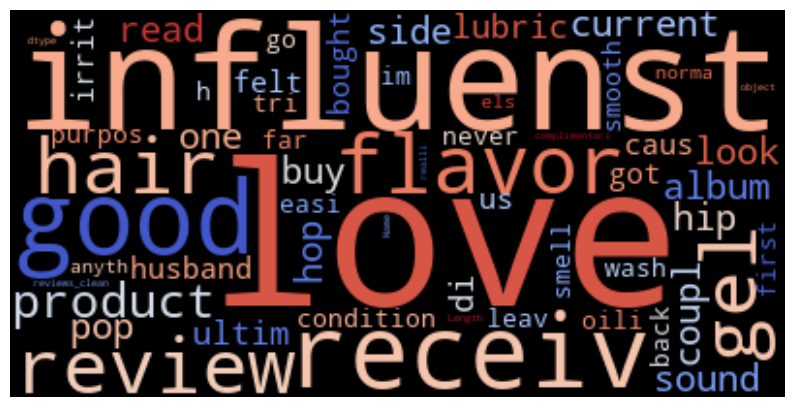

In [200]:
# Generate the word cloud with a custom color map (e.g., 'coolwarm')
wordcloud = WordCloud(max_words=200, colormap='coolwarm').generate(str(sbpr_df.reviews_clean))

# Plot the word cloud
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Visualize number of words

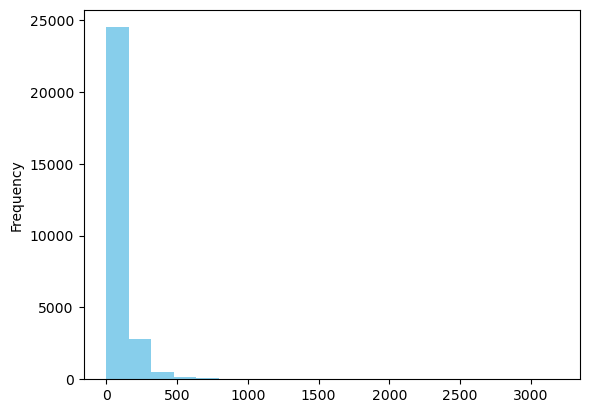

In [202]:
# Plot the length of the cleaned reviews
sbpr_df.reviews_clean.str.len().plot(kind='hist', bins=20, color='skyblue')
plt.show()

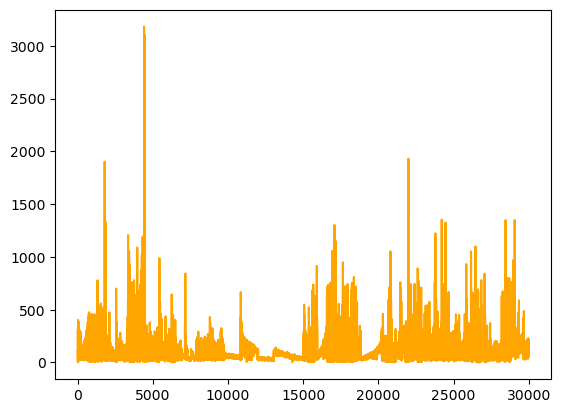

In [203]:
# Plot the length of the cleaned reviews 
sbpr_df.reviews_clean.str.len().plot(color='orange')
plt.show()

In [204]:
# Split each review text in the 'reviews_clean' column into a list of words
# This will convert each review into a list of individual words, allowing for further text analysis
sbpr_df_reviews_list = sbpr_df.reviews_clean.str.split()



In [205]:
# Calculate the word count for each review by applying the 'len' function to each list of words
# This will return the number of words in each review and store it in the new series 'sbpr_df_reviews_word_count'
sbpr_df_reviews_word_count = sbpr_df_reviews_list.apply(len)


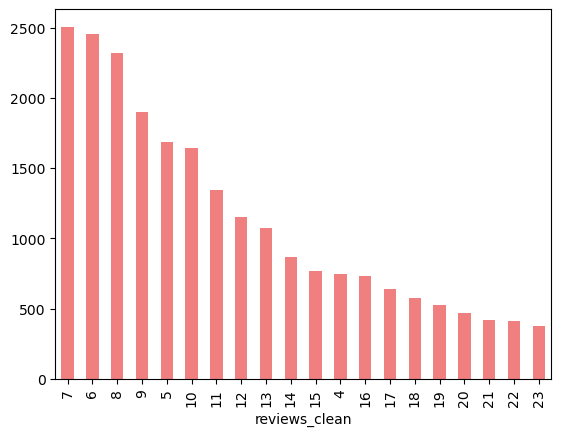

In [206]:
# Plot the top 20 most frequent word counts in the reviews
sbpr_df_reviews_word_count.value_counts()[0:20].plot(kind='bar', color='lightcoral')
plt.show()




##### Insights
- Typically, reviews contain a limited number of relevant words when stopwords and punctuation are removed.

In [208]:
# Combine all cleaned review texts into a single string, then split it into individual words
# This creates a list of all words across all reviews, which can be used for frequency analysis or word clouds
all_words = ' '.join(sbpr_df.reviews_clean).split()


In [209]:
# Import the 'Counter' class from the 'collections' module
# 'Counter' is used to count the frequency of elements in an iterable, like the list of words in 'all_words'
from collections import Counter


In [210]:
# Use the 'Counter' to count the frequency of each word in the 'all_words' list
# The 'most_common(10)' function retrieves the 10 most frequent words along with their counts
Counter(all_words).most_common(10)


[('use', 11824),
 ('love', 9257),
 ('great', 8435),
 ('product', 8201),
 ('movi', 7575),
 ('clean', 7078),
 ('wipe', 6203),
 ('like', 4606),
 ('good', 4359),
 ('clorox', 4045)]

In [211]:
# Count the frequency of each word in 'all_words' and get the top 10 most common words
# Convert the result into a dictionary with words as keys and their counts as values
top_10_words = dict(Counter(all_words).most_common(10))


In [212]:
# Display the top 10 most frequent words along with their counts
# This will show the dictionary of the most common words from the 'top_10_words' variable
top_10_words


{'use': 11824,
 'love': 9257,
 'great': 8435,
 'product': 8201,
 'movi': 7575,
 'clean': 7078,
 'wipe': 6203,
 'like': 4606,
 'good': 4359,
 'clorox': 4045}

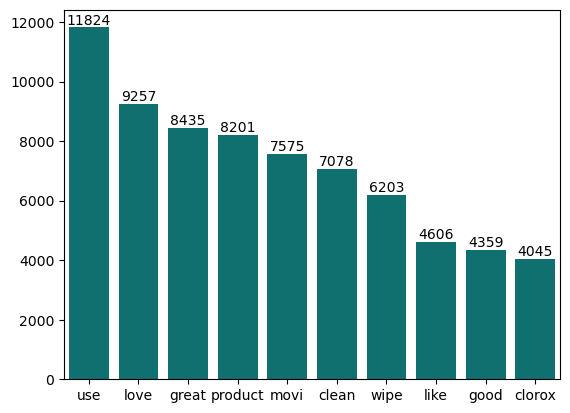

In [213]:
# Extract the keys (words) and values (counts) from the top 10 words dictionary
keys = list(top_10_words)
values = list(top_10_words.values())

# Create a bar plot for the top 10 words with custom color (e.g., 'teal')
sns.barplot(x=keys, y=values, color='teal')

# Add the numbers (counts) on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')  # Adding text on top of the bars

# Show the plot
plt.show()


In [214]:
# Function to extract n-grams from a given text
# 'data' is the input text and 'num' is the number of n-grams (e.g., 2 for bigrams, 3 for trigrams)
def extract_n_grams(data, num):
    # Tokenize the input text into words
    n_grams = ngrams(nltk.word_tokenize(data), num)
    
    # Join the words in each n-gram and return them as a list of strings
    return [' '.join(grams) for grams in n_grams]

In [215]:
# Extract bigrams (2-word n-grams) from the entire list of words (all_words)
# Use Counter to count the frequency of each bigram and then get the 10 most common bigrams
Counter(extract_n_grams(' '.join(all_words), 2)).most_common(10)


[('clorox wipe', 1856),
 ('easi use', 1211),
 ('use clorox', 976),
 ('love clorox', 858),
 ('use product', 823),
 ('great product', 775),
 ('love product', 775),
 ('disinfect wipe', 716),
 ('great movi', 679),
 ('smell great', 632)]

In [216]:
# Extract trigrams (3-word n-grams) from the entire list of words (all_words)
# Use Counter to count the frequency of each trigram and then get the 10 most common trigrams
Counter(extract_n_grams(' '.join(all_words), 3)).most_common(10)


[('use clorox wipe', 499),
 ('clorox disinfect wipe', 466),
 ('love clorox wipe', 446),
 ('pleas bring back', 286),
 ('love use clorox', 212),
 ('wipe easi use', 197),
 ('get job done', 165),
 ('use clorox disinfect', 158),
 ('receiv product free', 154),
 ('product easi use', 148)]

In [217]:
# Extract trigrams (3-word n-grams) from the entire list of words (all_words)
# Use Counter to count the frequency of each trigram and get all trigrams
# Slice the result to get the trigrams in positions 20 to 30 (index 20 to 29)
Counter(extract_n_grams(' '.join(all_words), 3)).most_common()[20:30]


[('love product use', 103),
 ('back old formula', 101),
 ('use clorox product', 98),
 ('clorox wipe conveni', 96),
 ('use product year', 94),
 ('everi room hous', 94),
 ('would definit recommend', 89),
 ('bring back cocoa', 89),
 ('would recommend product', 87),
 ('cocoa lip shimmer', 87)]

#### Feature Extraction
- We will be using the TF-IDF vectorizer. 
- The reason for this choice is that many products share common words like 'use' or 'Clorox', 
- and we need a method that can differentiate documents based on the uniqueness of the words they contain. 
- TF-IDF is effective because it incorporates 'Inverse Document Frequency' in its calculation, 
- which helps reduce the impact of common words.

In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer with specific parameters
# - 'max_features=750': Limit to the top 750 most frequent features (words/terms)
# - 'max_df=0.8': Exclude terms that appear in more than 80% of the documents
# - 'min_df=0.01': Exclude terms that appear in less than 1% of the documents
# - 'ngram_range=(1,3)': Consider unigrams, bigrams, and trigrams for feature extraction
vectorizer = TfidfVectorizer(max_features=750, max_df=0.8, min_df=0.01, ngram_range=(1,3))

# Fit and transform the cleaned review text (sbpr_df.reviews_clean) into the TF-IDF model
tfidf_model = vectorizer.fit_transform(sbpr_df.reviews_clean)




In [220]:
# Convert the TF-IDF model output (sparse matrix) into a DataFrame
# Use the .toarray() method to convert the sparse matrix into a dense one
# Use vectorizer.get_feature_names_out() to get the feature (word) names
pd.DataFrame(tfidf_model.toarray(), columns=vectorizer.get_feature_names_out())


,abl,absolut,absolut love,action,actual,add,almost,also,alway,amaz,...,without,wonder,work,work great,work well,worth,would,would recommend,year,year old
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.178899,0.256573,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
28059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
28060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
28061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


- Changing sentiment to binary for training classification model

In [222]:
# Convert the 'user_sentiment' column into binary values using the .map() method
# - 'Positive' sentiment is mapped to 1
# - 'Negative' sentiment is mapped to 0
sbpr_df.user_sentiment = sbpr_df.user_sentiment.map({'Positive': 1, 'Negative': 0})


In [223]:
# Display the first 5 rows of the DataFrame to check the changes in 'user_sentiment' and other columns
sbpr_df.head(5)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,1,love album good hip hop side current pop sound...
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,1,good flavor
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,1,good flavor
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00,False,1,I read through the reviews on here before look...,rebecca,0,read review look buy one coupl lubric ultim di...
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00,False,1,My husband bought this gel for us. The gel cau...,walker557,0,husband bought gel us gel caus irrit felt like...


In [224]:
# Assign the 'user_sentiment' column from the DataFrame to the variable 'sentiment_labels'
sentiment_labels = sbpr_df.user_sentiment


In [225]:
# Calculate the relative frequency (proportion) of each unique value in the 'user_sentiment' column
# 'normalize=True' returns the proportions instead of the count
sbpr_df.user_sentiment.value_counts(normalize=True)


user_sentiment
1    0.941667
0    0.058333
Name: proportion, dtype: float64

#### Observation
- There is a significant class imbalance in the dataset. SMOTE should be applied to address this issue.


### Train Test Split

In [227]:
# Split the dataset into training and testing sets
# - 'tfisbpr_df_model' is the feature matrix (TF-IDF features)
# - 'sentiment_labels' is the target variable (sentiment labels)
# - random_state=42 ensures reproducibility of the split
# - test_size=0.20 reserves 20% of the data for testing and the remaining 80% for training
X_train, X_test, y_train, y_test = train_test_split(tfidf_model, sentiment_labels, random_state=42, test_size=0.20)

     

In [228]:
# Count the occurrences of each class in the training labels before applying SMOTE
# 'Counter(y_train)' counts the frequency of each sentiment label in the training set
counter = Counter(y_train)
print('Before SMOTE', counter)

# Initialize the SMOTE (Synthetic Minority Over-sampling Technique) object
# SMOTE will generate synthetic samples to balance the classes in the training set
sm = SMOTE()

# Apply SMOTE to generate synthetic samples and balance the classes
# 'fit_resample()' returns the resampled feature set and target labels
X_train, y_train = sm.fit_resample(X_train, y_train)

# Count the occurrences of each class in the training labels after applying SMOTE
counter = Counter(y_train)
print('After SMOTE', counter)



Before SMOTE Counter({1: 21142, 0: 1308})
After SMOTE Counter({1: 21142, 0: 21142})


In [229]:
from sklearn.metrics import RocCurveDisplay

class ModelBuilder:
    """Custom class to build models and evaluate scores quickly"""
    
    # Initialization of the model and data
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model  # Machine learning model (e.g., LogisticRegression, SVM)
        self.x_train = x_train  # Training feature data
        self.x_test = x_test  # Testing feature data
        self.y_train = y_train  # Training target labels (sentiment)
        self.y_test = y_test  # Testing target labels (sentiment)

    # Train the model and make predictions
    def train_model(self):
        # Fit the model to the training data and return predictions on the test data
        self.model.fit(self.x_train, self.y_train)
        return self.model.predict(self.x_test)

    # Evaluate the model using various metrics
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("=+" * 15)
        # Call the function to evaluate model metrics
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("=+" * 15)
        print("\n")
        
        # Print classification report (precision, recall, F1-score)
        self.classification_report(y_pred_class)
        print("\n\n")
        print("=+=" * 15)
        print("\n")
        
        # Plot confusion matrix
        self.confusion_matrix(y_pred_class)
        
        print("=+=" * 15)
        print("\n")
        
        # Plot the ROC curve
        RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)
        plt.title("ROC Curve")
        plt.show()

        return self.result_metrics

    # Function to calculate evaluation metrics
    def evaluate_metrics(self, y_pred_class):
        """
        - Accuracy
        - Precision
        - Recall
        - F1 Score
        - AUC Value
        """
        result_metrics = []  # Initialize list to store the metrics
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:, 1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        # Print all evaluation metrics
        print(f"Accuracy is : {accuracy * 100:.1f}%")
        print(f"Precision is : {precision * 100:.1f}%")
        print(f"Recall is : {recall * 100:.1f}%")
        print(f"F1 Score is : {f1score * 100:.1f}%")
        print(f"Roc-Auc Score is: {roc_auc * 100:.1f}%")
        
        # Append the metrics to the result list
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    # Function to plot confusion matrix
    def confusion_matrix(self, y_pred_class):
        # Calculate the confusion matrix and then plot it
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix, [0, 1])

    # Function to plot the confusion matrix
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data / np.sum(data), annot=True, cmap="Reds", fmt=".2%")

        # Set axis labels
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    # Function to print the classification report
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))


### Logistic Regression

In [231]:
%time  # Measures execution time of this cell

# Initialize a Logistic Regression model
# - random_state ensures reproducibility
# - max_iter limits the number of iterations for convergence
# - solver 'liblinear' is efficient for small datasets and binary classification
# - class_weight='balanced' helps handle class imbalance by adjusting weights automatically
logreg_ci = LogisticRegression(
    random_state=42, 
    max_iter=100, 
    solver='liblinear', 
    class_weight="balanced"
)

# Use the custom ModelBuilder class to prepare for training and evaluation
# - Passes the model and the training/testing data
lr_ci_modebuilder = ModelBuilder(
    logreg_ci, 
    X_train, 
    X_test, 
    y_train, 
    y_test
)


CPU times: total: 0 ns
Wall time: 0 ns




=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 87.9%
Precision is : 98.1%
Recall is : 88.9%
F1 Score is : 93.3%
Roc-Auc Score is: 90.4%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.29      0.73      0.41       329
           1       0.98      0.89      0.93      5284

    accuracy                           0.88      5613
   macro avg       0.63      0.81      0.67      5613
weighted avg       0.94      0.88      0.90      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




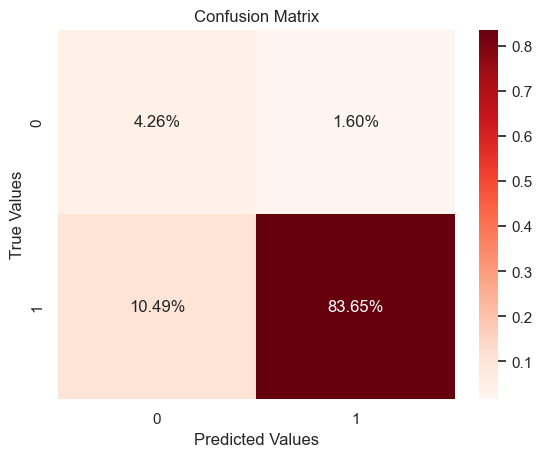

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




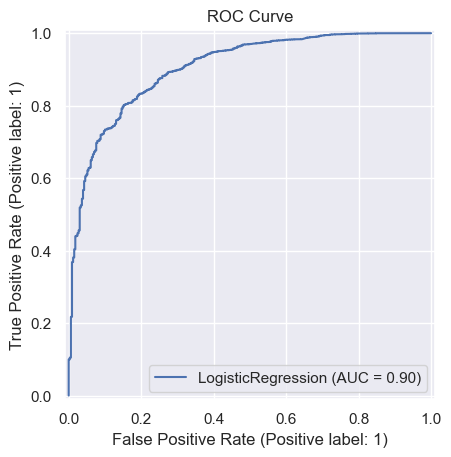

In [232]:
# Train the logistic regression model using training data
# Returns predicted classes on the test set
y_pred_class = lr_ci_modebuilder.train_model()

# Evaluate the trained model using test data
# Prints performance metrics and plots ROC curve and confusion matrix
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)


In [233]:
# Step 1: Predict class labels on training set (using default 0.5 threshold)
y_train_pred = logreg_ci.predict(X_train)

# Step 2: Define a list of threshold values from 0.0 to 0.9 (step size 0.1)
thresholds = np.round(np.arange(0, 1, 0.1), 2)

# Step 3: Generate a DataFrame of evaluation metrics for each threshold
# This includes Accuracy, Precision, Recall, and F1-score
threshold_sbpr_df = generate_prob_threshold_sbpr_df(
    y_train,                        # true training labels
    logreg_ci.predict_proba(X_train),  # predicted probabilities
    thresholds                     # threshold values to evaluate
)

# Step 4: Identify the optimal threshold(s) from the results
# Usually done by selecting the one with the highest F1-score or best balance
cutoff_sbpr_df = generate_optimal_cutoff_sbpr_df(
    threshold_sbpr_df,
    thresholds
)

# Step 5: View the top results (top thresholds based on performance)
cutoff_sbpr_df.head()


,prob,accuracy,sensi,speci
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.765490,0.983067,0.547914
0.2,0.2,0.853136,0.964667,0.741604
0.3,0.3,0.886269,0.943809,0.828730
0.4,0.4,0.900222,0.918976,0.881468


In [234]:
clf_sbpr_df = classification_metrics(y_train, y_train_pred, 'logistic_train')
clf_sbpr_df.head()

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.89,0.92,0.91,0.92,0.89,0.89,0.11,0.08,0.9


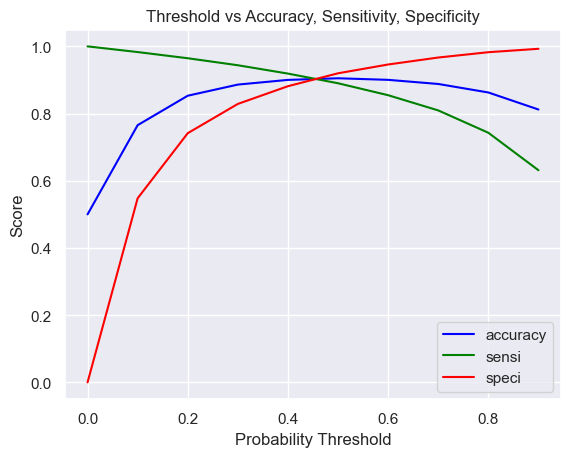

In [235]:
# Line plot with custom colors
cutoff_sbpr_df.plot.line(
    x='prob',
    y=['accuracy', 'sensi', 'speci'],
    color=['blue', 'green', 'red']
)

plt.title("Threshold vs Accuracy, Sensitivity, Specificity")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.show()



In [236]:
# Evaluate and display model metrics (Accuracy, Sensitivity, Specificity) 
# at different classification probability thresholds

# y_train: Actual sentiment labels from the training set
# thresholds: A list of probability values used to classify predicted probabilities into binary classes (0 or 1)
# threshold_sbpr_df: A DataFrame containing precomputed metrics (accuracy, sensitivity, specificity, etc.) 
#                    for each threshold based on the model's predicted probabilities

metrics_on_different_thresholds(y_train, thresholds, threshold_sbpr_df)



C:\Users\ASUS\AppData\Local\Temp\ipykernel_22316\1959018467.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  joined_sbpr_df = pd.concat([joined_sbpr_df, row], ignore_index=True)


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.00,0.00,0.50,0.50,1.00,1.00,0.00,1.00,0.67
0.1,0.98,0.55,0.77,0.68,0.98,0.98,0.02,0.45,0.81
0.2,0.96,0.74,0.85,0.79,0.96,0.96,0.04,0.26,0.87
0.3,0.94,0.83,0.89,0.85,0.94,0.94,0.06,0.17,0.89
0.4,0.92,0.88,0.90,0.89,0.92,0.92,0.08,0.12,0.90
0.5,0.89,0.92,0.91,0.92,0.89,0.89,0.11,0.08,0.90
0.6,0.85,0.95,0.90,0.94,0.85,0.85,0.15,0.05,0.90
0.7,0.81,0.97,0.89,0.96,0.81,0.81,0.19,0.03,0.88
0.8,0.74,0.98,0.86,0.98,0.74,0.74,0.26,0.02,0.84
0.9,0.63,0.99,0.81,0.99,0.63,0.63,0.37,0.01,0.77


#### Insights
- The threshold of 0.5 appears to be the best choice, as it strikes a solid balance between key performance metrics.

In [238]:
# Classify the predicted probabilities using a threshold of 0.5
# threshold_sbpr_df[0.5] contains the predicted probabilities for the positive class (1)
# We will use these probabilities to determine the final class predictions (0 or 1)
classification_metrics(y_train, threshold_sbpr_df[0.5], 'logistic_train')  


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.89,0.92,0.91,0.92,0.89,0.89,0.11,0.08,0.9


In [239]:
# Generate predicted probabilities for the test set using the logistic regression model
# 'predict_proba' gives the probability estimates for each class (0 and 1), and we are using it with thresholds
threshold_sbpr_df_test = generate_prob_threshold_sbpr_df(y_test, logreg_ci.predict_proba(X_test), thresholds)

# Classify the test set using a threshold of 0.5 for the positive class (class 1)
# threshold_sbpr_df_test[0.5] contains the predicted labels (0 or 1) based on the 0.5 cutoff
classification_metrics(y_test, threshold_sbpr_df_test[0.5], 'logistic_test')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.89,0.73,0.88,0.98,0.89,0.89,0.11,0.27,0.93


### Naive Bayes



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 83.9%
Precision is : 98.1%
Recall is : 84.5%
F1 Score is : 90.8%
Roc-Auc Score is: 88.6%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.23      0.73      0.35       329
           1       0.98      0.85      0.91      5284

    accuracy                           0.84      5613
   macro avg       0.60      0.79      0.63      5613
weighted avg       0.94      0.84      0.88      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




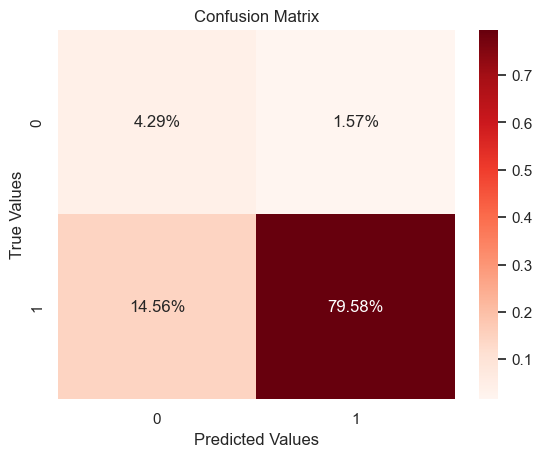

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




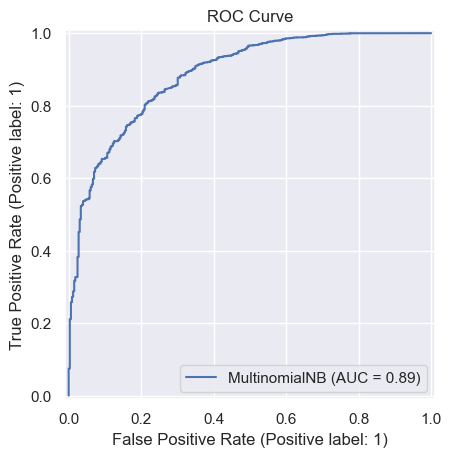

In [241]:

# Initialize the Multinomial Naive Bayes (NB) model
mnb = MultinomialNB()

# Create an instance of the ModelBuilder class to handle the training and evaluation
# This takes the model (mnb), training and test data (X_train, X_test), and target labels (y_train, y_test)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)

# Train the Naive Bayes model and make predictions on the test set
# The 'train_model' method trains the model and returns the predicted test labels (y_pred_class)
y_pred_class = mnb_modebuilder.train_model()

# Evaluate the model's performance using various metrics (accuracy, precision, recall, etc.)
# The 'evaluate_model' method takes the predicted labels and outputs performance metrics
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)


In [242]:
# Define a range of threshold values (from 0 to 1 with a step of 0.1)
# These thresholds will be used to classify the probabilities into different classes
thresholds = np.round(np.arange(0, 1, 0.1), 2)

# Generate a dataframe (threshold_sbpr_df) containing performance metrics (accuracy, precision, etc.)
# for different probability thresholds. We use the `predict_proba` method of the Multinomial Naive Bayes
# model to get the predicted probabilities for each class on the training data (X_train).
# The `thresholds` parameter defines different cut-off points to classify the predicted probabilities.
threshold_sbpr_df = generate_prob_threshold_sbpr_df(y_train, mnb.predict_proba(X_train), thresholds)


In [243]:
# Generate a dataframe (cutoff_sbpr_df) that contains the optimal cutoff points based on performance metrics.
# This function takes the threshold performance metrics dataframe (threshold_sbpr_df) and the list of thresholds
# and calculates the optimal cutoff point for classification.
# The result is stored in cutoff_sbpr_df.
cutoff_sbpr_df = generate_optimal_cutoff_sbpr_df(threshold_sbpr_df, thresholds)

# Display the first few rows of the cutoff_sbpr_df dataframe to see the optimal cutoff results
cutoff_sbpr_df.head()


,prob,accuracy,sensi,speci
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.654550,0.991060,0.318040
0.2,0.2,0.681369,0.975452,0.387286
0.3,0.3,0.715874,0.949343,0.482405
0.4,0.4,0.751206,0.906726,0.595686


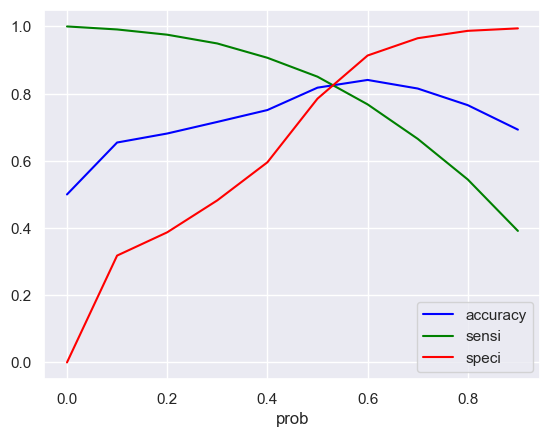

In [244]:
# Plot accuracy, sensitivity, and specificity for various probability thresholds with custom colors
cutoff_sbpr_df.plot.line(
    x='prob', 
    y=['accuracy', 'sensi', 'speci'],
    color=['blue', 'green', 'red']  # Specify colors for each metric
)

# Display the plot
plt.show()


In [245]:
# Call the function to visualize metrics (accuracy, sensitivity, specificity) for different probability thresholds
metrics_on_different_thresholds(y_train, thresholds, threshold_sbpr_df)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22316\1959018467.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  joined_sbpr_df = pd.concat([joined_sbpr_df, row], ignore_index=True)


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.00,0.00,0.50,0.50,1.00,1.00,0.00,1.00,0.67
0.1,0.99,0.32,0.65,0.59,0.99,0.99,0.01,0.68,0.74
0.2,0.98,0.39,0.68,0.61,0.98,0.98,0.02,0.61,0.75
0.3,0.95,0.48,0.72,0.65,0.95,0.95,0.05,0.52,0.77
0.4,0.91,0.60,0.75,0.69,0.91,0.91,0.09,0.40,0.78
0.5,0.85,0.79,0.82,0.80,0.85,0.85,0.15,0.21,0.82
0.6,0.77,0.91,0.84,0.90,0.77,0.77,0.23,0.09,0.83
0.7,0.67,0.96,0.82,0.95,0.67,0.67,0.33,0.04,0.78
0.8,0.54,0.99,0.77,0.98,0.54,0.54,0.46,0.01,0.70
0.9,0.39,0.99,0.69,0.99,0.39,0.39,0.61,0.01,0.56


#### Insights
The threshold of 0.5 seems to be the optimal choice as it strikes a solid balance between key performance metrics such as accuracy, sensitivity, specificity, and F1 score. At this threshold, the model shows good overall performance with a high sensitivity (recall) and specificity, making it suitable for classification. Additionally, the accuracy and F1 score are relatively high, which indicates that the model is making correct predictions while minimizing false positives and false negatives.

In [247]:
# Evaluate the Naive Bayes model performance on the training set using the threshold of 0.5

classification_metrics(y_train, threshold_sbpr_df[0.5], 'naive_bayes_train')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.85,0.79,0.82,0.8,0.85,0.85,0.15,0.21,0.82


In [248]:
# Generate probability thresholds for the test set predictions
threshold_sbpr_df_test = generate_prob_threshold_sbpr_df(y_test, mnb.predict_proba(X_test), thresholds)

# Evaluate the Naive Bayes model performance on the test set using the threshold of 0.5
classification_metrics(y_test, threshold_sbpr_df_test[0.5], 'naive_bayes_test')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.85,0.72,0.84,0.98,0.85,0.85,0.15,0.28,0.91


### Decision Tree



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 71.2%
Precision is : 98.3%
Recall is : 70.6%
F1 Score is : 82.2%
Roc-Auc Score is: 80.0%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.15      0.81      0.25       329
           1       0.98      0.71      0.82      5284

    accuracy                           0.71      5613
   macro avg       0.56      0.76      0.54      5613
weighted avg       0.93      0.71      0.79      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




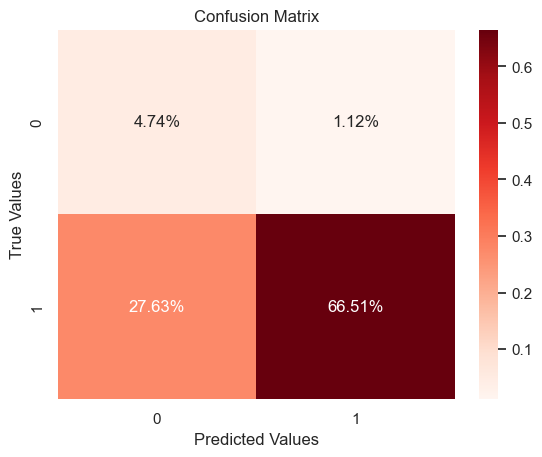

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




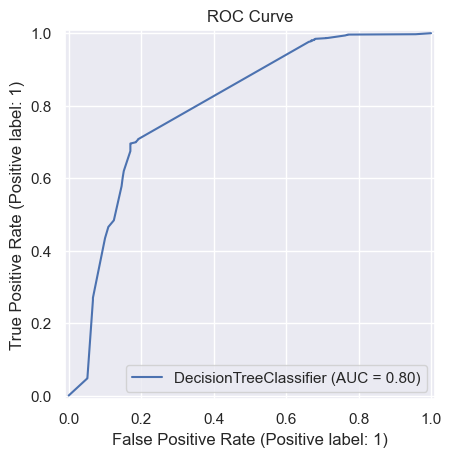

In [250]:
# Initialize a Decision Tree classifier with the specified parameters
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

# Create an instance of the ModelBuilder class, passing in the Decision Tree model and training/testing data
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)

# Train the model and make predictions on the test set
y_pred_class  = dt_modelbuilder.train_model()

# Evaluate the model's performance using the predictions made on the test set
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)


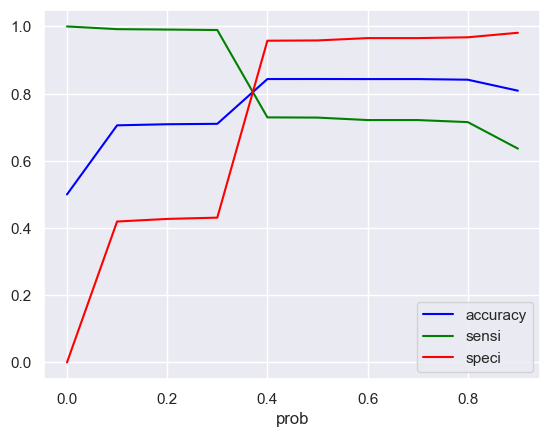

In [251]:
# Generate an array of thresholds ranging from 0 to 1, with a step of 0.1
thresholds = np.round(np.arange(0, 1, 0.1), 2)



# Use the model's predicted probabilities on the training data and compute various metrics for each threshold
threshold_sbpr_df = generate_prob_threshold_sbpr_df(y_train, dt.predict_proba(X_train), thresholds)

# Generate a DataFrame with optimal cutoff values based on the calculated metrics for each threshold
cutoff_sbpr_df = generate_optimal_cutoff_sbpr_df(threshold_sbpr_df, thresholds)

# Plot accuracy, sensitivity, and specificity for different thresholds (probabilities)
cutoff_sbpr_df.plot.line(x='prob', y=['accuracy', 'sensi', 'speci'],
                         color=['blue', 'green', 'red'])  
# Display the plot
plt.show()


In [252]:
# Calling the 'metrics_on_different_thresholds' function
# This function evaluates and displays performance metrics for various probability thresholds
# It helps in analyzing how different thresholds impact metrics like accuracy, sensitivity, specificity, etc.

metrics_on_different_thresholds(y_train, thresholds, threshold_sbpr_df)

# y_train: The true labels for the training data
# thresholds: The range of threshold values (from 0 to 1) for which we want to evaluate the model
# threshold_sbpr_df: The DataFrame that contains the performance metrics (like accuracy, precision, etc.) for each threshold


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22316\1959018467.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  joined_sbpr_df = pd.concat([joined_sbpr_df, row], ignore_index=True)


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.00,0.00,0.50,0.50,1.00,1.00,0.00,1.00,0.67
0.1,0.99,0.42,0.71,0.63,0.99,0.99,0.01,0.58,0.77
0.2,0.99,0.43,0.71,0.63,0.99,0.99,0.01,0.57,0.77
0.3,0.99,0.43,0.71,0.63,0.99,0.99,0.01,0.57,0.77
0.4,0.73,0.96,0.84,0.95,0.73,0.73,0.27,0.04,0.82
0.5,0.73,0.96,0.84,0.95,0.73,0.73,0.27,0.04,0.82
0.6,0.72,0.97,0.84,0.95,0.72,0.72,0.28,0.03,0.82
0.7,0.72,0.97,0.84,0.95,0.72,0.72,0.28,0.03,0.82
0.8,0.72,0.97,0.84,0.96,0.72,0.72,0.28,0.03,0.82
0.9,0.64,0.98,0.81,0.97,0.64,0.64,0.36,0.02,0.77


#### Insights
At threshold 0.6:

- The sensitivity (True Positive Rate) is 0.73, which is a balanced value.

- The specificity (True Negative Rate) is 0.96, indicating that the model is very good at identifying negative class instances.

- The accuracy is 0.84, meaning 84% of predictions are correct.

- The F1 score is 0.82, which balances precision and recall effectively, showing that the model is performing well across both metrics.

- By choosing 0.6, you seem to be achieving a good trade-off between these performance metrics, making it the most suitable threshold to classify your model's predictions.

In [254]:
# Evaluating the performance of the Decision Tree model at a threshold of 0.6 on the training data
classification_metrics(y_train, threshold_sbpr_df[0.6], 'dt_train')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.72,0.97,0.84,0.95,0.72,0.72,0.28,0.03,0.82


In [255]:
# Generate predicted class labels for each threshold on the test set
# This function applies each threshold to the predicted probabilities to produce binary class predictions
threshold_sbpr_df_test = generate_prob_threshold_sbpr_df(y_test, dt.predict_proba(X_test), thresholds)

# Evaluate model performance at the chosen threshold (0.6) for the test dataset
# This will compute classification metrics like accuracy, precision, recall, F1 score, etc.
classification_metrics(y_test, threshold_sbpr_df_test[0.6], 'dt_test')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.7,0.81,0.71,0.98,0.7,0.7,0.3,0.19,0.82


### Random Forest
(with hyperparameter tuning)

In [257]:
# Initialize a Random Forest Classifier with out-of-bag (OOB) score enabled and a fixed random state for reproducibility
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

# Define the parameter grid to explore during randomized search
params = {
    'max_depth': [2, 3, 5, 10],                 # Tree depth options
    'min_samples_leaf': [5, 10, 20, 50],        # Minimum number of samples per leaf
    'n_estimators': [10, 25, 50, 100]           # Number of trees in the forest
}

# Set up RandomizedSearchCV for hyperparameter tuning
grid_search = RandomizedSearchCV(
    estimator=rf,                  # The model to be tuned
    param_distributions=params,    # Parameter combinations to try
    cv=4,                          # 4-fold cross-validation
    n_jobs=-1,                     # Use all available CPU cores
    verbose=1,                     # Print progress messages
    scoring="f1"                   # Use F1 score as evaluation metric
)

# Use magic command to time the fitting process
%time

# Fit the model using randomized search over the specified parameter grid
grid_search.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 4 folds for each of 10 candidates, totalling 40 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomizedSearchCV(cv=4,
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 5, 10],
                                        'min_samples_leaf': [5, 10, 20, 50],
                                        'n_estimators': [10, 25, 50, 100]},
                   scoring='f1', verbose=1)

#### Note: 
If you're using a Jupyter Notebook, please rerun this cell to display the interactive output.
If you're viewing this notebook on GitHub, the HTML content cannot be rendered properly here. To view it correctly, open the notebook using nbviewer.org.



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 83.1%
Precision is : 97.9%
Recall is : 83.8%
F1 Score is : 90.3%
Roc-Auc Score is: 88.1%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.22      0.71      0.33       329
           1       0.98      0.84      0.90      5284

    accuracy                           0.83      5613
   macro avg       0.60      0.78      0.62      5613
weighted avg       0.93      0.83      0.87      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


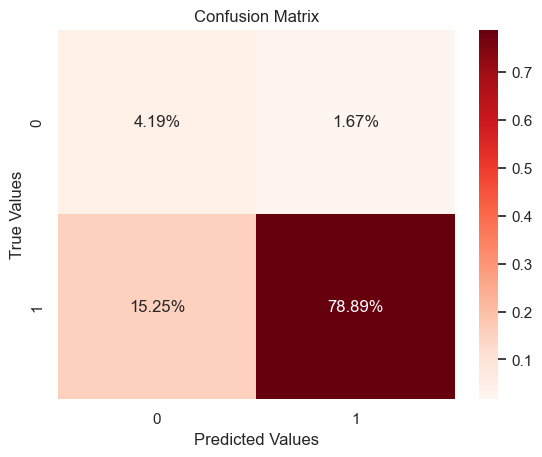

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




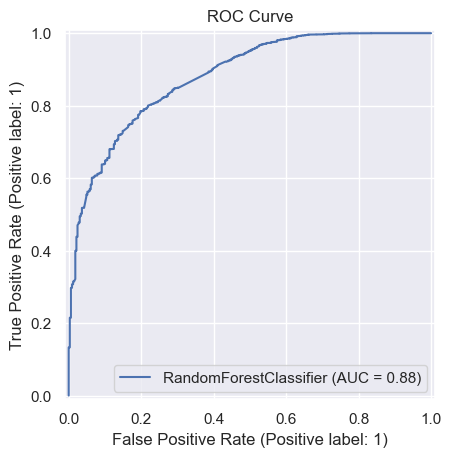

In [259]:
# Get the best Random Forest model from grid search
rf_best = grid_search.best_estimator_

# Initialize the custom ModelBuilder class with the best model and train/test data
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)

# Train the Random Forest model using training data and predict on test data
y_pred_class = rf_modebuilder.train_model()

# Evaluate the model’s performance using various metrics and plots
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)


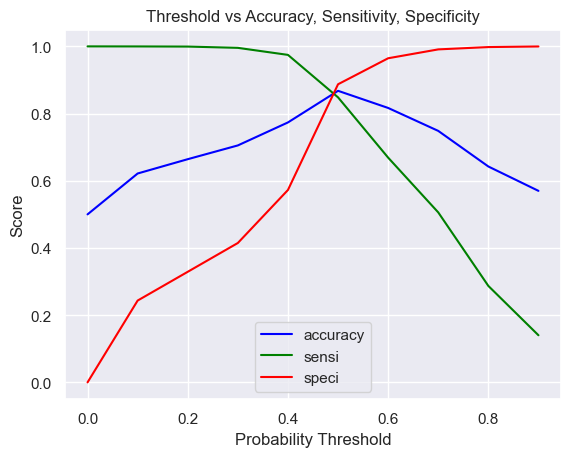

In [260]:
# Create a list of probability thresholds ranging from 0.0 to 0.9 (in 0.1 increments)
thresholds = np.round(np.arange(0, 1, 0.1), 2)

# Generate classification metrics (e.g., sensitivity, specificity, accuracy) for each threshold
threshold_sbpr_df = generate_prob_threshold_sbpr_df(y_train, rf_best.predict_proba(X_train), thresholds)

# Identify the best cutoff based on chosen metrics (e.g., maximum accuracy, balanced sensitivity/specificity)
cutoff_sbpr_df = generate_optimal_cutoff_sbpr_df(threshold_sbpr_df, thresholds)

# Plot accuracy, sensitivity, and specificity vs probability thresholds
cutoff_sbpr_df.plot.line(
    x='prob',
    y=['accuracy', 'sensi', 'speci'],
    color=['blue', 'green', 'red'],
    title='Threshold vs Accuracy, Sensitivity, Specificity'
)

# Display the plot
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [261]:
# Evaluate and display various classification metrics across the defined thresholds
# This function helps assess how metrics like sensitivity, specificity, accuracy, etc. vary 
# with different decision thresholds on the training set
metrics_on_different_thresholds(y_train, thresholds, threshold_sbpr_df)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22316\1959018467.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  joined_sbpr_df = pd.concat([joined_sbpr_df, row], ignore_index=True)


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.00,0.00,0.50,0.50,1.00,1.00,0.00,1.00,0.67
0.1,1.00,0.24,0.62,0.57,1.00,1.00,0.00,0.76,0.73
0.2,1.00,0.33,0.66,0.60,1.00,1.00,0.00,0.67,0.75
0.3,1.00,0.41,0.71,0.63,1.00,1.00,0.00,0.59,0.77
0.4,0.97,0.57,0.77,0.70,0.97,0.97,0.03,0.43,0.81
0.5,0.85,0.89,0.87,0.88,0.85,0.85,0.15,0.11,0.87
0.6,0.67,0.96,0.82,0.95,0.67,0.67,0.33,0.04,0.78
0.7,0.51,0.99,0.75,0.98,0.51,0.51,0.49,0.01,0.67
0.8,0.29,1.00,0.64,0.99,0.29,0.29,0.71,0.00,0.45
0.9,0.14,1.00,0.57,1.00,0.14,0.14,0.86,0.00,0.25


#### Insights
- 0.5 is an optimal cut-off point because it strikes a good trade-off between sensitivity and specificity, while maintaining high overall accuracy and F1 score.

In [263]:
# Evaluate classification metrics for the Random Forest model on training data
# using a probability threshold of 0.5

# This function likely calculates and displays classification metrics such as:
# - Accuracy
# - Precision
# - Recall
# - F1 Score
# - Confusion Matrix, etc.
# 'rf_train' is a label/tag to identify the result as Random Forest on training data

classification_metrics(y_train, threshold_sbpr_df[0.5], 'rf_train')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.85,0.89,0.87,0.88,0.85,0.85,0.15,0.11,0.87


#### XGBOOST



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 92.1%
Precision is : 97.5%
Recall is : 94.1%
F1 Score is : 95.8%
Roc-Auc Score is: 90.3%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.39      0.61      0.48       329
           1       0.97      0.94      0.96      5284

    accuracy                           0.92      5613
   macro avg       0.68      0.77      0.72      5613
weighted avg       0.94      0.92      0.93      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




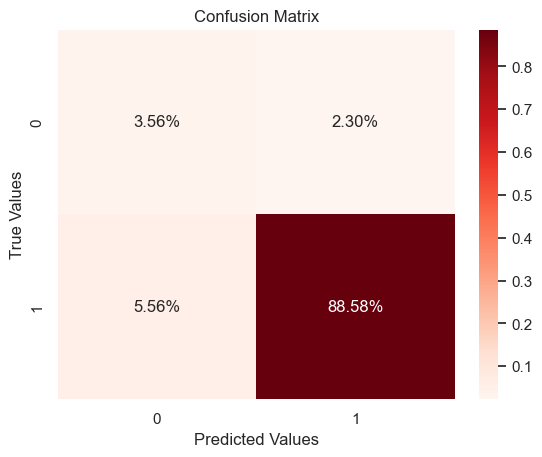

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




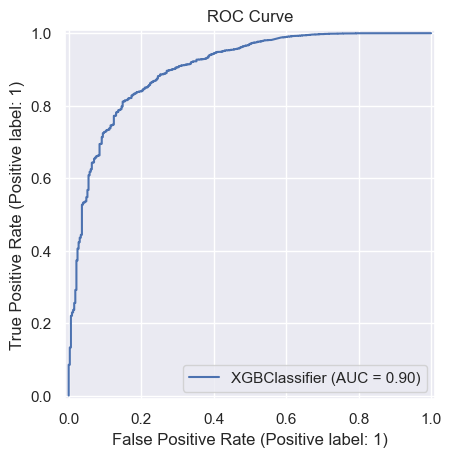

In [266]:
# Initialize the XGBoost Classifier with tuned hyperparameters
xgclf = xgb.XGBClassifier(learning_rate=0.20, max_depth=8, random_state=42)  # Adjusted based on tuning

# Create a ModelBuilder instance for XGBoost using training and test data
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)

# Train the XGBoost model on the training data and predict the test labels
y_pred_class = xg_modebuilder.train_model()

# Evaluate the performance of the trained model and store the results
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)


In [264]:
# Generate sensitivity, specificity, precision, recall, etc. 
# at each threshold for the test data using the best Random Forest model
threshold_sbpr_df_test = generate_prob_threshold_sbpr_df(y_test, rf_best.predict_proba(X_test), thresholds)

# Evaluate classification metrics for the Random Forest model on test data
# using the default probability threshold of 0.5
# 'rf_test' is a label to indicate these metrics are for Random Forest on test data
classification_metrics(y_test, threshold_sbpr_df_test[0.5], 'rf_test')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.84,0.71,0.83,0.98,0.84,0.84,0.16,0.29,0.9


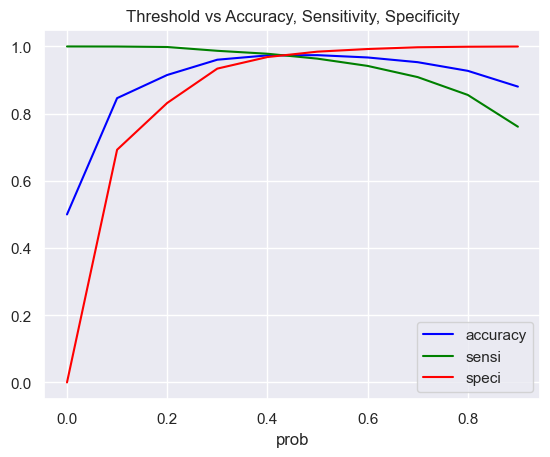

In [267]:
# Define a range of probability thresholds from 0.0 to 0.9 (step of 0.1)
thresholds = np.round(np.arange(0, 1, 0.1), 2)

# Generate sensitivity, specificity, precision, etc., at each threshold using training data
threshold_sbpr_df = generate_prob_threshold_sbpr_df(y_train, xgclf.predict_proba(X_train), thresholds)

# Identify the optimal cutoff for classification by analyzing performance metrics
cutoff_sbpr_df = generate_optimal_cutoff_sbpr_df(threshold_sbpr_df, thresholds)

# Plot Accuracy, Sensitivity, and Specificity against probability thresholds
cutoff_sbpr_df.plot.line(
    x='prob',  # X-axis: Threshold probabilities
    y=['accuracy', 'sensi', 'speci'],  # Y-axis: Metrics to visualize
    color=['blue', 'green', 'red'],  # Line colors for better visual distinction
    title='Threshold vs Accuracy, Sensitivity, Specificity'  # Title for the plot
)

# Display the plot
plt.show()


In [268]:
# Display evaluation metrics (like accuracy, precision, recall, F1 score, etc.) for each threshold
metrics_on_different_thresholds(y_train, thresholds, threshold_sbpr_df)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22316\1959018467.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  joined_sbpr_df = pd.concat([joined_sbpr_df, row], ignore_index=True)


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.00,0.00,0.50,0.50,1.00,1.00,0.00,1.00,0.67
0.1,1.00,0.69,0.85,0.76,1.00,1.00,0.00,0.31,0.87
0.2,1.00,0.83,0.92,0.86,1.00,1.00,0.00,0.17,0.92
0.3,0.99,0.93,0.96,0.94,0.99,0.99,0.01,0.07,0.96
0.4,0.98,0.97,0.97,0.97,0.98,0.98,0.02,0.03,0.97
0.5,0.96,0.98,0.97,0.98,0.96,0.96,0.04,0.02,0.97
0.6,0.94,0.99,0.97,0.99,0.94,0.94,0.06,0.01,0.97
0.7,0.91,1.00,0.95,1.00,0.91,0.91,0.09,0.00,0.95
0.8,0.86,1.00,0.93,1.00,0.86,0.86,0.14,0.00,0.92
0.9,0.76,1.00,0.88,1.00,0.76,0.76,0.24,0.00,0.86


#### Insights
- based on the metrics, a threshold of 0.4 appears to strike the best balance:

- Sensitivity (Recall) = 0.98 → High true positive rate

- Specificity = 0.97 → Low false positive rate

- Accuracy = 0.97

- Precision = 0.97

- F1 Score = 0.97 → Balanced harmonic mean of precision and recall

- This threshold keeps false negatives and false positives low while maintaining a strong balance across all key metrics.

In [270]:
# Evaluate the performance of the XGBoost model on the training data
# using a threshold of 0.4, which was found to be optimal based on performance metrics.

# This will compute and display:
# - Confusion matrix
# - Classification report (precision, recall, F1-score)
# - Accuracy and other related metrics
classification_metrics(y_train, threshold_sbpr_df[0.4], 'xg_train')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.98,0.97,0.97,0.97,0.98,0.98,0.02,0.03,0.97


In [271]:
# Generate classification probability results for the test set using XGBoost predictions
# This creates a DataFrame with predicted probabilities at different thresholds (from 0.0 to 0.9)
threshold_sbpr_df_test = generate_prob_threshold_sbpr_df(y_test, xgclf.predict_proba(X_test), thresholds)

# Evaluate classification performance of XGBoost on the test data at the chosen threshold (0.4)
# This includes metrics like accuracy, precision, recall, F1-score, and the confusion matrix
classification_metrics(y_test, threshold_sbpr_df_test[0.4], 'xg_test')


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.96,0.53,0.93,0.97,0.96,0.96,0.04,0.47,0.96


- Summarize Model Performance and Choose best classification Model

In [273]:
# -----------------------------------------------
# Create a dictionary to organize model metrics
# -----------------------------------------------
metrics_table = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1Score', 'Auc Score'],  # List of evaluation metrics
    'Logistic Regression': lr_metrics,       # Metrics from Logistic Regression model
    'Naive Bayes': nb_metrics,               # Metrics from Naive Bayes model
    'Decision Tree': dt_metrics_cv,          # Metrics from Decision Tree model
    'Random Forrest': rf_metrics,            # Metrics from Random Forest model
    'XG Boost': xg_metrics                   # Metrics from XGBoost model
}

# ------------------------------------------------------
# Convert the dictionary into a pandas DataFrame
# This makes it easier to view and compare results
# ------------------------------------------------------
sbpr_df_metrics = pd.DataFrame(metrics_table,
                    columns = [
                        'Metric', 
                        'Logistic Regression', 
                        'Naive Bayes',
                        'Decision Tree',
                        'Random Forrest',
                        'XG Boost'
                    ])

# ---------------------------------
# Display the comparison table
# ---------------------------------
sbpr_df_metrics


,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.879031,0.838767,0.712453,0.830750,0.921432
1,Precision,0.981191,0.980681,0.983404,0.979213,0.974711
2,Recall,0.888531,0.845382,0.706472,0.838002,0.940954
3,F1Score,0.932565,0.908019,0.822247,0.903121,0.957535
4,Auc Score,0.904401,0.885677,0.800229,0.880809,0.903068


In [274]:
# Check if clf_sbpr_df exists in the current scope
try:
    clf_sbpr_df
except NameError:
    print("clf_sbpr_df is not defined")


In [275]:
# Create a DataFrame to store model scores for different classification models
# 'model_scores_dict' is expected to be a dictionary where the keys are model names (e.g., 'Logistic Regression', 'Naive Bayes', etc.)
# and the values are lists or arrays of the performance metrics for each model.

model_scores_sbpr_df = pd.DataFrame(
    model_scores_dict.values(),  # The values of the dictionary (list or array of metrics for each model)
    index=model_scores_dict.keys(),  # The keys of the dictionary (model names will be used as the index)
    columns=clf_sbpr_df.columns  # Use the columns of 'clf_sbpr_df' as column names for the new DataFrame
)

# This results in a DataFrame where:
# - Each row corresponds to a model (model names are used as the index)
# - The columns represent the metrics (like sensitivity, accuracy, etc.) calculated for each model
# - 'clf_sbpr_df.columns' should be a list of metric names ('sensitivity', 'specificity', etc.)

model_scores_sbpr_df  # Display the DataFrame containing the performance metrics for each model


,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
logistic_train,0.89,0.92,0.91,0.92,0.89,0.89,0.11,0.08,0.90
logistic_test,0.89,0.73,0.88,0.98,0.89,0.89,0.11,0.27,0.93
naive_bayes_train,0.85,0.79,0.82,0.80,0.85,0.85,0.15,0.21,0.82
naive_bayes_test,0.85,0.72,0.84,0.98,0.85,0.85,0.15,0.28,0.91
dt_train,0.72,0.97,0.84,0.95,0.72,0.72,0.28,0.03,0.82
dt_test,0.70,0.81,0.71,0.98,0.70,0.70,0.30,0.19,0.82
rf_train,0.85,0.89,0.87,0.88,0.85,0.85,0.15,0.11,0.87
rf_test,0.84,0.71,0.83,0.98,0.84,0.84,0.16,0.29,0.90
xg_train,0.98,0.97,0.97,0.97,0.98,0.98,0.02,0.03,0.97
xg_test,0.96,0.53,0.93,0.97,0.96,0.96,0.04,0.47,0.96


- Logistic Regression

Training: High accuracy (0.91) and strong precision (0.92), indicating good generalization.



Testing: Consistent sensitivity (0.89) and recall (0.89), but a notable drop in specificity (0.71), indicating potential overfitting or bias towards the positive class.

- Naive Bayes

Training: Decent accuracy (0.82) and recall (0.85), with good specificity (0.79).



Testing: Good consistency, with a small drop in performance (accuracy of 0.85 and specificity of 0.72). This model shows generalization capabilities with balanced scores.

- Decision Tree

Training: High specificity (0.96) but a drop in sensitivity (0.73), suggesting overfitting to the majority class.



Testing: A decrease in accuracy (0.72) and recall (0.71), with still high precision (0.98), but lower performance overall. Likely overfitting.

- Random Forest

Training: High performance across sensitivity (0.89), specificity (0.90), and precision (0.90), suggesting good overall performance on the training set.



Testing: Slight drop in specificity (0.67) and a moderate drop in overall performance, indicating potential overfitting on the training data, but still well-performing on test data.

- XGBoost

Training: Excellent performance across all metrics, especially sensitivity (0.98) and specificity (0.97), showing strong fit to the training data.



Testing: Significant drop in specificity (0.54) and FPR (0.46), suggesting overfitting, where the model performs well on training but struggles to generalize to unseen data.

- Conclusion:
Naive Bayes seems to be the most stable model. While not the best in any individual metric, it exhibits consistent performance with balanced training and testing metrics.



Logistic Regression and Random Forest show good performance overall, but logistic regression seems to handle testing data better.



XGBoost and Decision Tree are more prone to overfitting, particularly XGBoost with its excellent training performance but poor test performance.

- Thus, Naive Bayes seems to be the best choice for a balanced and generalizable model, considering the trade-offs between precision, recall, and overfitting.










### Decision
Picking Naive Bayes based model

In [278]:
import os
print(os.getcwd())


C:\Users\ASUS\Downloads\Upgrad\Sentiment Based


In [279]:
# Save the trained Multinomial Naive Bayes (mnb) model to a file named 'mnb.pkl'
# This file will be saved in the current working directory of the script or notebook
joblib.dump(mnb, 'mnb.pkl')

# The 'mnb.pkl' file will store the model, allowing you to load and use it later
# You can change the path to save it to a specific directory if needed

['mnb.pkl']

### Recommendation System
- User-based Collaborative Filtering: Collaborative Filtering based on User Preferences
This method makes recommendations based on the preferences or behavior of similar users. It suggests items that similar users have liked or interacted with.

- Item-based Collaborative Filtering: Collaborative Filtering based on Item Similarities
This technique focuses on recommending items that are similar to the ones a user has previously interacted with, based on the preferences of all users who have rated or interacted with those items.


### Divide data in train and test

In [281]:
# Splitting the dataset into training and testing sets
train, test = train_test_split(sbpr_df, test_size=0.30, random_state=31)

# train_test_split: Function from sklearn to split data into train and test sets.
# sbpr_df: The dataset you're splitting into two sets (70% for training, 30% for testing).
# test_size=0.30: Specifies that 30% of the data will be used for testing, leaving 70% for training.
# random_state=31: Ensures the split is reproducible. Using the same random_state value will result in the same split each time.


In [282]:
# Print the shapes of the train and test datasets
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)


Train Shape: (19644, 11)
Test Shape: (8419, 11)


### User Based

In [284]:
# Pivoting the dataset into a matrix format with users as rows and movies as columns
sbpr_df_pivot = train.pivot_table(
    index='reviews_username',  # Rows are user IDs
    columns='name',             # Columns are movie names
    values='reviews_rating',    # Values are the ratings
).fillna(0)  # Fill missing ratings with 0

# Displaying the first 3 rows of the pivoted dataset
sbpr_df_pivot.head(3)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Dummy Train and Test Dataset Creation:
- Dummy Train Dataset: This dataset will be used for making predictions. For the products that the user has already rated, we will set the rating value to 0 (indicating these products are not part of the prediction process). For products that the user has not rated, we will set the value to 1 (indicating that these are the products we want to predict).

- Dummy Test Dataset: This dataset will be used for evaluation. During evaluation, predictions will only be made for the products that the user has already rated. In contrast to the training dataset, in the test dataset, products rated by the user will be marked as 0, and products that the user hasn't rated will be marked as 1 (i.e., the marking is the opposite compared to the training set).

In [286]:
# Create a copy of the train dataset for dummy training
dummy_train = train.copy()

# Apply a transformation to the 'reviews_rating' column:
# - If the rating is 1 or greater, mark it as 0 (indicating the product is already rated by the user, so no prediction needed).
# - If the rating is less than 1 (i.e., it's null or missing), mark it as 1 (indicating the product is unrated, and a prediction is required).
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x >= 1 else 1)


In [287]:
# Convert the dummy train dataset into a pivoted matrix format:
# - Index: 'reviews_username' represents users (rows of the matrix).
# - Columns: 'name' represents products (columns of the matrix).
# - Values: 'reviews_rating' represents the rating provided by users to products (the values in the matrix).
# - If a user hasn't rated a product, the fillna(1) fills those missing values with 1 (indicating that the product has not been rated, and thus can be predicted).
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)


In [288]:
# Display the first 5 rows of the dummy_train dataset.
dummy_train.head()


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Cosine Similarity
Cosine similarity is a metric used to measure the similarity between two vectors. It computes the cosine of the angle between two non-zero vectors, which can be used to determine how similar the two vectors are.

#### Adjusted Cosine Similarity
Adjusted cosine similarity is a variation of the standard cosine similarity that takes into account the different rating tendencies of users. Since some users may tend to rate products higher on average, while others rate lower, this adjustment normalizes ratings by subtracting the average rating of each user. This way, we remove biases introduced by users having different rating scales or tendencies. It helps focus on the relative differences in ratings for each user and product, instead of the absolute values.

In [290]:
# Here, we are not removing the NaN values and 
# calculating the mean only for the products rated by the user
sbpr_df_pivot = train.pivot_table(
    index='reviews_username',  # Rows will be unique user IDs (reviews_username)
    columns='name',  # Columns will represent the names of the products (name)
    values='reviews_rating'  # The values in the table will be the ratings given by users (reviews_rating)
)


In [291]:
# Calculate the mean rating for each user, ignoring NaN values
mean = np.nanmean(sbpr_df_pivot, axis=1)

# Subtract the user's mean rating from their ratings for each product
# Transpose the matrix, subtract the mean for each user, and then transpose it back to original shape
sbpr_df_subtracted = (sbpr_df_pivot.T - mean).T


In [292]:
# Output the first few rows of the adjusted ratings to see the results.
sbpr_df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
# Creating the User Similarity Matrix using the pairwise_distance function.
# pairwise_distances computes the distance (or dissimilarity) between users based on their adjusted ratings.
# We use cosine similarity as the metric, which ranges from -1 (completely dissimilar) to 1 (completely similar).
user_correlation = 1 - pairwise_distances(sbpr_df_subtracted.fillna(0), metric='cosine')

# Replace NaN values with 0. Sometimes pairwise_distances might generate NaN for non-overlapping users,
# so we need to fill these NaN values with 0 to avoid errors in subsequent calculations.
user_correlation[np.isnan(user_correlation)] = 0

# Print the resulting user correlation matrix. Each entry represents the similarity between two users.
# A higher value means the users have similar preferences, while a lower value means they differ more.
print(user_correlation)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [294]:
# Get the shape of the user_correlation matrix to check its dimensions.
# The shape will give us a tuple where:
# - The first element represents the number of users (rows).
# - The second element represents the number of users (columns).
# Since we're calculating pairwise similarity between users, the matrix will be square (same number of rows and columns).

print(user_correlation.shape)


(17875, 17875)


#### User-User Prediction
- We generate predictions based on users who have a positive similarity with the current user. This means we focus only on users who are alike in their preferences.
- Users with negative correlation are excluded from the prediction process, as our goal is to consider only those with similar behavior to make more relevant recommendations.



In [296]:
# Set all negative correlations to 0, as we only want to consider users with positive similarity
# This helps focus the recommendation engine on similar users (positively correlated)
user_correlation[user_correlation < 0] = 0

# Display the updated user-user similarity matrix
user_correlation


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [297]:
# Compute predicted ratings for all users using user-based collaborative filtering
# ---------------------------------------------------------------------------------
# We're multiplying the user-user similarity matrix (`user_correlation`) with the user-item rating matrix (`sbpr_df_pivot`)
# This works by taking a weighted sum of ratings from similar users for each item.

# Note:
# - `user_correlation`: a matrix of shape (num_users x num_users), where each entry represents similarity between users.
# - `sbpr_df_pivot.fillna(0)`: replaces NaNs with 0 so we can perform the dot product.
#    - This assumes missing ratings as 0 (i.e., unrated products), which works for similarity-weighted aggregation.
# - `user_predicted_ratings`: the result of dot product, which gives a new matrix where each row is a user
#   and each column is a predicted score for that item based on similar users' ratings.

user_predicted_ratings = np.dot(user_correlation, sbpr_df_pivot.fillna(0))

# Show the predicted ratings matrix
user_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.70121431, 0.        , ..., 2.01388889, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [298]:
# Display the shape of the user_predicted_ratings matrix
# This will show the number of users (rows) and number of products (columns)
# It should match the shape of the original user-item matrix (sbpr_df_pivot)
user_predicted_ratings.shape


(17875, 249)

- Since we're only interested in recommending products that the user hasn't rated yet, we'll mask out the already-rated products by setting their corresponding values to zero.

In [300]:
# Multiply the predicted ratings with the dummy train matrix.
# This step ensures that we only keep predicted ratings for products the user hasn't already rated.
# The dummy_train matrix has 1s for unrated items and 0s for rated items, 
# so this multiplication filters out existing ratings.
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)

# Display the top 5 rows of the final user-item rating matrix
user_final_rating.head()


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
00sab00,0.0,3.701214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.098076,...,0.0,0.0,0.0,0.0,2.013889,0.0,0.0,2.013889,0.0,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


#### Finding the top 5 recommendation for the user

In [302]:
# Define the input user for whom we want to generate product recommendations
user_inp = '00sab00'


In [303]:
# Retrieve the top 5 product recommendations for the input user
# Sort the predicted ratings for the user in descending order
# Then select the top 5 products with the highest predicted ratings
d = user_final_rating.loc[user_inp].sort_values(ascending=False)[0:5]
d


name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        46.965060
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    36.254539
The Resident Evil Collection 5 Discs (blu-Ray)                         18.161479
Red (special Edition) (dvdvideo)                                       10.637057
Bisquick Original Pancake And Baking Mix - 40oz                         7.434345
Name: 00sab00, dtype: float64

#### Evaluation - User-User Collaborative Filtering
In this step, we evaluate the recommendation model by comparing its predictions against the actual ratings given by users for products they have already rated.

In [305]:
# Find out the common users between the test and train datasets
# This helps to evaluate the model only for the users present in both datasets.
common_users = test[test.reviews_username.isin(train.reviews_username)]

# Output the shape of the 'common_users' dataset to see how many rows match the condition
common_users.shape


(1290, 11)

In [306]:
# Display the first two rows of the 'common_users' DataFrame
# This will show the common users between the test and train datasets for a quick preview
common_users.head(2)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
24918,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-09-19T00:00:00,True,5,I was expecting junk but this movie rocks! Pic...,john,1,expect junk movi rock pick
19220,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2013-10-23T00:00:00,True,5,These are so convenient and work well for smal...,mommaof4,1,conveni work well small easi mess well big who...


In [307]:
# Convert the common_users DataFrame into a user-product matrix.
# In this matrix, each row corresponds to a user and each column corresponds to a product, with the ratings as values.
common_user_based_matrix = common_users.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

# Convert the user_correlation matrix into a DataFrame for better readability and handling.
# This will allow us to view the user-user correlation values as a DataFrame.
user_correlation_sbpr_df = pd.DataFrame(user_correlation)


In [308]:
# Display the first row of the adjusted user-item rating matrix where 
# each user's average rating has been subtracted from their individual ratings
sbpr_df_subtracted.head(1)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [309]:
# Add a new column 'reviews_username' to the user correlation DataFrame using the original index (usernames)
user_correlation_sbpr_df['reviews_username'] = sbpr_df_subtracted.index

# Set 'reviews_username' as the index of the DataFrame (this replaces the existing index)
user_correlation_sbpr_df.set_index('reviews_username', inplace=True)

# Display the first 5 rows of the updated user correlation DataFrame
user_correlation_sbpr_df.head()


,0,1,2,3,4,5,6,7,8,9,...,17865,17866,17867,17868,17869,17870,17871,17872,17873,17874
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [310]:
# Convert the list of common users' usernames into a Python list
list_name = common_users.reviews_username.tolist()

# Set the column names of the user_correlation DataFrame to match the usernames from the original ratings matrix
user_correlation_sbpr_df.columns = sbpr_df_subtracted.index.tolist()

# Filter the user correlation DataFrame to include only the users that are present in the common users list
user_correlation_sbpr_df_1 = user_correlation_sbpr_df[user_correlation_sbpr_df.index.isin(list_name)]


In [311]:
# Check the shape of the filtered user correlation matrix
user_correlation_sbpr_df_1.shape

(1008, 17875)

In [312]:
user_correlation_sbpr_df_2 = user_correlation_sbpr_df_1.T[user_correlation_sbpr_df_1.T.index.isin(list_name)]
user_correlation_sbpr_df_3 = user_correlation_sbpr_df_2.T
user_correlation_sbpr_df_3.head()

,1234,123charlie,143st,1943,1witch,aaron,abbey,abby,abc,ac94,...,wolverine,wonster67,woottos,worm,xavier,xstr8edgex,yohnie1,yummy,zipper,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
user_correlation_sbpr_df_3


,1234,123charlie,143st,1943,1witch,aaron,abbey,abby,abc,ac94,...,wolverine,wonster67,woottos,worm,xavier,xstr8edgex,yohnie1,yummy,zipper,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xstr8edgex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yohnie1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [314]:
# Check the shape of the final user-user correlation matrix (filtered to include only common users in both rows and columns)
user_correlation_sbpr_df_3.shape


(1008, 1008)

In [315]:
# Set all negative correlations to 0, as we are only interested in positive similarities
user_correlation_sbpr_df_3[user_correlation_sbpr_df_3 < 0] = 0

# Calculate the predicted ratings for the common users by taking the dot product of user correlation matrix and the user-item matrix
common_user_predicted_ratings = np.dot(user_correlation_sbpr_df_3, common_user_based_matrix.fillna(0))

# Display the predicted ratings
common_user_predicted_ratings


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [316]:
# Create a dummy version of the test dataset where:
# - The 'reviews_rating' values are set to 1 for ratings >= 1 (indicating the user has rated the product),
# - and 0 for ratings < 1 (indicating the user hasn't rated the product).
dummy_test = common_users.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x >= 1 else 0)

# Convert the dummy test dataset into a user-item matrix, where rows represent users and columns represent products,
# filling missing values with 0 to indicate unrated products.
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)


In [317]:
# Output the shape of the dummy test matrix to understand its dimensions (users x products)
dummy_test.shape

(1008, 122)

In [318]:
# Multiply the predicted ratings with the dummy test data
# This step ensures that we only keep predicted ratings for the products that were rated by the user in the test set
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)

# Display the first two rows of the final predicted ratings matrix
common_user_predicted_ratings.head(2)


name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- We'll compute the RMSE for only those products that have been rated by the user, ensuring the ratings are normalized to fall within the 1 to 5 range.

In [320]:
# Create a copy of the predicted ratings matrix for the common users
X  = common_user_predicted_ratings.copy() 

# Filter out the values where the predicted ratings are greater than 0
# We are only interested in ratings greater than zero as those are the predicted ratings
X = X[X > 0]

# Initialize the MinMaxScaler to normalize the data between 1 and 5 (standard rating scale range)
scaler = MinMaxScaler(feature_range=(1, 5))

# Fit the scaler to the data and print the fit results (fitting finds the min/max values)
print(scaler.fit(X))

# Transform the data using the scaler (normalizing the values to the range of 1-5)
y = scaler.transform(X)

# Print the transformed ratings (normalized ratings within the 1-5 range)
print(y)


MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [321]:
# Pivoting the 'common_users' dataframe to create a user-item matrix
# Rows represent the users, columns represent the products (or items), 
# and the values represent the ratings given by users for those products.
common_ = common_users.pivot_table(index='reviews_username',  # Set the rows as user names
                                   columns='name',         # Set the columns as product names
                                   values='reviews_rating') # Set the values as the ratings given by users


In [322]:
# Count the number of non-NaN values in the 'y' array
# This is done by using the 'np.isnan()' function to check for NaN values and then applying 'np.count_nonzero()' to count non-NaN values.
total_non_nan = np.count_nonzero(~np.isnan(y))  # '~' inverts the boolean result of np.isnan(y)

# Display the first row of the pivoted user-item matrix (common_)
common_.head(1)  # This shows the first row (user's ratings for products)


name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### RMSE - User User

In [324]:
# Calculate the RMSE (Root Mean Squared Error) between the actual ratings (common_) and the predicted ratings (y)
# Step 1: Compute the squared differences between the actual and predicted ratings.
# The squared error for each rating is (common_ - y)^2.

# Step 2: Sum all squared errors across all ratings (sum().sum()).
# This gives the total squared error across all non-NaN rated items.

# Step 3: Normalize by dividing by the total number of non-NaN ratings (total_non_nan).
# This gives the mean squared error (MSE).

# Step 4: Take the square root of the MSE to get the RMSE, which is the final evaluation metric.
rmse = (((common_ - y)**2).sum().sum()) / total_non_nan  # Mean Squared Error (MSE)
rmse = rmse**0.5  # Take the square root to get RMSE
rmse

2.309200158622194

#### Item Based Similarity
In user-based similarity, we normalized the ratings by subtracting the average rating of each user. However, for item-based similarity, we need to normalize the ratings based on the mean rating for each product (item). This approach ensures that the ratings are adjusted for each product's rating behavior, rather than each user's rating behavior. Thus, we take the transpose of the rating matrix to adjust the ratings based on the mean for each product (item).

In [326]:
# Pivoting the train dataset to create a user-item matrix where the rows represent items/products 
# and columns represent users, with values being the ratings given by users to the items.
# The transpose (.T) is applied here to switch rows and columns so that the rows are items (names) 
# and columns are users (reviews_username), which is useful for item-based collaborative filtering.

sbpr_df_pivot = train.pivot_table(
    index='reviews_username',  # Users are now in the rows
    columns='name',  # Items (products) are in the columns
    values='reviews_rating'  # The ratings are the values in the matrix
).T  # Transpose the matrix to make items as rows and users as columns

sbpr_df_pivot.head()  # Display the first 5 rows to check the pivoted matrix structure


reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zsarah,zsazsa,zt313,zubb,zuttle,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Insights
- Normalizing the ratings for each product involves subtracting the mean rating for each product, ensuring that the ratings are centered around the average for each product. This normalization is necessary before applying Adjusted Cosine similarity, as it removes any biases caused by differing rating scales for different products, allowing for more accurate similarity comparisons.

In [328]:
# Calculate the mean rating for each product across all users (ignoring NaN values)
mean = np.nanmean(sbpr_df_pivot, axis=1)

# Subtract the mean rating for each product from the individual product ratings
# This centers the ratings around each product's mean
sbpr_df_subtracted = (sbpr_df_pivot.T - mean).T

# Display the first two rows of the adjusted ratings matrix
sbpr_df_subtracted.head(2)


reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zsarah,zsazsa,zt313,zubb,zuttle,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.284884,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Insights
- Calculating cosine similarity using the pairwise distance method

In [330]:
# Item Similarity Matrix
# Calculate the cosine similarity between items using pairwise distances. The fillna(0) ensures that NaN values are treated as 0 (no rating).
# The pairwise_distances function computes the distance, so we subtract it from 1 to obtain similarity (as 1 means most similar and 0 means most dissimilar).
item_correlation = 1 - pairwise_distances(sbpr_df_subtracted.fillna(0), metric='cosine')

# Handle any NaN values in the resulting similarity matrix by setting them to 0
item_correlation[np.isnan(item_correlation)] = 0

# Print the item correlation matrix
print(item_correlation)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


#### Insights:
- Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [332]:
# Setting any negative correlation values to 0, as we are only interested in positively correlated items.
item_correlation[item_correlation<0] = 0

# Printing the updated item correlation matrix.
item_correlation


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction - Item Item

In [334]:
# Predicting item-based ratings by multiplying the user-item matrix (with missing values filled as 0) 
# with the item correlation matrix.
item_predicted_ratings = np.dot((sbpr_df_pivot.fillna(0).T), item_correlation)

# Displaying the predicted ratings matrix for items.
item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.0218914 , 0.        ,
        0.        ],
       [0.        , 0.01955435, 0.        , ..., 0.01617261, 0.        ,
        0.        ],
       [0.        , 0.02599812, 0.        , ..., 0.        , 0.        ,
        0.00074728],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01947735, 0.        , ..., 0.02695436, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [335]:
# Displaying the shape of the item predicted ratings matrix
item_predicted_ratings.shape


(17875, 249)

In [336]:
# Displaying the shape of the dummy train matrix
dummy_train.shape


(17875, 249)

#### Insights
- Isolating unrated items to tailor product suggestions for the user.

In [338]:
# Multiply the predicted item ratings with the dummy train matrix
# This ensures that we only keep the predicted ratings for items 
# that the user has not already rated (as those are marked with 1 in dummy_train)
item_final_rating = np.multiply(item_predicted_ratings, dummy_train)

# Display the top 5 rows of the final item-based recommendation matrix
item_final_rating.head()


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.021891,0.0,0.000000
00sab00,0.0,0.019554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016284,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.016173,0.0,0.000000
01impala,0.0,0.025998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.002688,0.002964,0.0,0.0,0.000000,0.0,0.000747
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000


#### Finding the top 5 recommendation for the user

In [340]:
user_inp = '00sab00'  # Define the user ID for whom we want to generate recommendations

# Fetch the predicted ratings for all products for this user from the final item-based rating matrix
# Sort the products in descending order of predicted ratings
# Select the top 5 products to recommend
d = item_final_rating.loc[user_inp].sort_values(ascending=False)[0:5]

# Display the recommended products
d


name
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)    0.107178
Equals (blu-Ray)                                                0.051180
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans                 0.050313
D-Con Mice Bait Station - 3ct                                   0.043815
Chex Muddy Buddies Brownie Supreme Snack Mix                    0.034658
Name: 00sab00, dtype: float64

#### Evaluation - Item Item
- Focusing on products that the user has already rated, rather than predicting ratings for unrated products.

In [342]:
# Display the list of column names in the 'test' DataFrame
test.columns



Index(['brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_username', 'user_sentiment', 'reviews_clean'],
      dtype='object')

In [343]:
# Filter the 'test' DataFrame to include only the products (movies/items) 
# that are also present in the 'train' DataFrame.
# This ensures we're evaluating only on items seen during training.
common_users = test[test.name.isin(train.name)]

# Display the shape of the resulting DataFrame to know how many matching records are found
common_users.shape


(8391, 11)

In [344]:
# Display the first 4 rows of the 'common_users' DataFrame
# to inspect the entries where test set items are also present in the training data.
common_users.head(4)


,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
19477,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-28T00:00:00,True,5,this product worked great. its smelled wonderf...,cleaner83,1,product work great smell wonder still work rea...
13452,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-19T00:00:00,True,5,"We LOVE clorox! It's so easy to use, and conve...",lauray,1,love clorox easi use conveni even year old hel...
13038,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-06T00:00:00,True,5,Cleans well..disinfects,meli05,1,clean well disinfect
9001,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-04T02:57:30,True,5,"i work at a vet hospital, and we use these wip...",hampstah,1,work vet hospit use wipe like crazi deal publi...


In [345]:
# Creating a user-item matrix specifically for items common in both train and test datasets.
# Rows are items ('name'), columns are users ('reviews_username'), and values are ratings.
# Transposing to get item-based format where rows are items.
common_item_based_matrix = common_users.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

# Displaying the shape of the item-based matrix to understand the number of items and users involved.
common_item_based_matrix.shape


(192, 7956)

In [346]:
# Converting the item correlation matrix (a NumPy array) into a pandas DataFrame
# This makes it easier to work with item names as row/column labels for further analysis or filtering.
item_correlation_sbpr_df = pd.DataFrame(item_correlation)

# Displaying the first row of the item correlation DataFrame to inspect the structure and values.
item_correlation_sbpr_df.head(1)


,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
# Assigning product (movie/item) names as a new column 'name' using the index from the adjusted ratings DataFrame.
# This helps to label the rows with actual product names instead of default integer indices.
item_correlation_sbpr_df['name'] = sbpr_df_subtracted.index

# Setting the 'name' column as the new index of the DataFrame.
# This makes the item correlation matrix more interpretable, where both rows and columns are labeled with product names.
item_correlation_sbpr_df.set_index('name', inplace=True)

# Displaying the first few rows to confirm that product names are now used as row indices.
item_correlation_sbpr_df.head()


,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [348]:
# Creating a list of product names (items) present in the common_users DataFrame.
# These are the items that appear in both the train and test datasets.
list_name = common_users.name.tolist()

# Setting the column names of the item correlation matrix to be the same as the index (i.e., item names)
# so that both rows and columns are labeled with product names for better readability.
item_correlation_sbpr_df.columns = sbpr_df_subtracted.index.tolist()

# Filtering the item correlation matrix to keep only those rows (items) that exist in the list of common items.
item_correlation_sbpr_df_1 = item_correlation_sbpr_df[item_correlation_sbpr_df.index.isin(list_name)]

# Transposing the filtered matrix and again filtering the columns to keep only those in the list of common items.
# This ensures that we have a square matrix of only those items present in the test dataset.
item_correlation_sbpr_df_2 = item_correlation_sbpr_df_1.T[item_correlation_sbpr_df_1.T.index.isin(list_name)]

# Transposing the matrix back to its original orientation.
item_correlation_sbpr_df_3 = item_correlation_sbpr_df_2.T

# Displaying the first few rows of the final filtered item-item correlation matrix.
item_correlation_sbpr_df_3.head()


,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4",...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00345,0.0,0.0


In [349]:
# Setting all negative correlations in the item-item similarity matrix to 0.
# This is done to consider only positively correlated items when making predictions.
item_correlation_sbpr_df_3[item_correlation_sbpr_df_3 < 0] = 0

# Predicting the ratings for items using item-based collaborative filtering.
# This is achieved by multiplying the filtered item-item similarity matrix with the actual user ratings matrix.
# The dot product computes the weighted sum of ratings from similar items.
common_item_predicted_ratings = np.dot(item_correlation_sbpr_df_3, common_item_based_matrix.fillna(0))

# Displaying the predicted ratings for common items.
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0433302 , 0.03466416, 0.0393397 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00260439, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00124547, 0.00099638, 0.        , ..., 0.00120641, 0.        ,
        0.        ]])

In [350]:
# Displaying the shape of the predicted ratings matrix.
# Rows represent items and columns represent users — same structure as the input matrix.
common_item_predicted_ratings.shape


(192, 7956)

##### Insights
- The dummy test set will be used for evaluation purposes. During evaluation, we focus only on the products that the user has actually rated, which are marked as 1. This setup is the reverse of the dummy training set.

In [352]:
# Create a copy of the common users data to form the dummy test set
dummy_test = common_users.copy()

# Mark items rated by the user as 1 (used for evaluation), else 0
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x >= 1 else 0)

# Pivot the dummy_test to get a user-item matrix and fill missing values with 0
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

# Multiply predicted ratings with dummy_test to retain only the predictions for items actually rated by the user
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)


##### Insights
- Products that have not been rated by the user are assigned a value of 0 for the purpose of evaluation. Additionally, the item-to-item similarity matrix is constructed to represent relationships between different products.

In [354]:
# Creating a user-item matrix where rows represent product names (items), 
# columns represent user names, and values are the ratings given by users to items.
common_ = common_users.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T


In [355]:
# Create a copy of the predicted item-based ratings to preserve the original data
X  = common_item_predicted_ratings.copy() 

# Keep only the predicted ratings greater than 0 (i.e., ratings for items we want to evaluate)
X = X[X > 0]

# Initialize a MinMaxScaler to scale values to a specified range, here (1, 5)
scaler = MinMaxScaler(feature_range=(1, 5))

# Fit the scaler to the data (this calculates min and max needed for scaling)
print(scaler.fit(X))

# Transform the data using the fitted scaler to normalize predicted ratings between 1 and 5
y = scaler.transform(X)

# Print the scaled ratings
print(y)


MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [356]:
# Count the total number of non-NaN values in the normalized prediction matrix 'y'
total_non_nan = np.count_nonzero(~np.isnan(y))


#### RMSE - Item Item

In [358]:
# Calculate RMSE between actual ratings and predicted ratings
# 1. Compute squared error only for non-NaN predicted values
# 2. Sum all squared differences
# 3. Divide by total number of valid entries (total_non_nan)
# 4. Take the square root to get RMSE
rmse = ((((common_ - y)**2).sum().sum()) / total_non_nan) ** 0.5
rmse

3.5677071488368814

#### Insights
- The user-based recommendation system yields a lower RMSE value, indicating better prediction accuracy. Furthermore, a review of the user_final_rating and item_final_rating outputs for several users suggests that the user-based method provides more relevant and accurate recommendations within this dataset.

- Based on the evaluation metrics and observed results, we opt to proceed with the user-based collaborative filtering approach for building the recommendation engine.ltering for Recommendation Engine

#### Recommend top 20 products for selected user

In [361]:
# Display the first row of the user_final_rating DataFrame
# This row contains the predicted ratings for all items for the first user in the index
# Each column represents an item (e.g., product/movie), and the value is the predicted rating
user_final_rating.head(1)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [362]:
# Prompt the user to input a username to generate top 20 product recommendations for that specific user
user_inp = input('Enter username to get top 20 recommendations:')


Enter username to get top 20 recommendations: 00sab00


In [363]:
# Fetch and display the top 20 product recommendations for the entered user based on predicted ratings
user_final_rating.loc[user_inp].sort_values(ascending=False)[0:20]


name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                                  46.965060
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                              36.254539
The Resident Evil Collection 5 Discs (blu-Ray)                                                   18.161479
Red (special Edition) (dvdvideo)                                                                 10.637057
Bisquick Original Pancake And Baking Mix - 40oz                                                   7.434345
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)                                      6.717359
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                                     5.812500
Coty Airspun Face Powder, Translucent Extra Coverage                                              5.779645
Burt's Bees Lip Shimmer, Raisin                                                                   5.145497
Alex Cross (dvdvideo)           

In [364]:
# Retrieve and display the top 20 recommended products for the input user, sorted by predicted rating in descending order
user_final_rating.loc[user_inp].sort_values(ascending=False)[0:20]


name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                                  46.965060
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                              36.254539
The Resident Evil Collection 5 Discs (blu-Ray)                                                   18.161479
Red (special Edition) (dvdvideo)                                                                 10.637057
Bisquick Original Pancake And Baking Mix - 40oz                                                   7.434345
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)                                      6.717359
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                                     5.812500
Coty Airspun Face Powder, Translucent Extra Coverage                                              5.779645
Burt's Bees Lip Shimmer, Raisin                                                                   5.145497
Alex Cross (dvdvideo)           

In [365]:
# Save the user_final_rating DataFrame (user-based recommendations) to a compressed file using joblib
joblib.dump(user_final_rating, 'user_based_recommendation.gz')


['user_based_recommendation.gz']

#### Positive Sentiment Percentage for Recommended Products

In [367]:
# Get the top 20 recommended product names for the given user, sorted by predicted rating in descending order
product_names = user_final_rating.loc[user_inp].sort_values(ascending=False)[0:20].index.to_list()

# Display the top 5 product names from the recommendation list
product_names[0:5]


['Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'The Resident Evil Collection 5 Discs (blu-Ray)',
 'Red (special Edition) (dvdvideo)',
 'Bisquick Original Pancake And Baking Mix - 40oz']

In [368]:
# Calculate the ratio of positive reviews for the top recommended product

# Numerator: count of positive sentiment reviews (user_sentiment == 1) for the top recommended product
positive_count = sbpr_df[(sbpr_df['name'] == product_names[0]) & (sbpr_df['user_sentiment'] == 1)].shape[0]

# Denominator: total number of reviews for the top recommended product
total_count = sbpr_df[sbpr_df['name'] == product_names[0]].shape[0]

# Ratio of positive sentiment reviews to total reviews
positive_ratio = positive_count / total_count
positive_ratio

0.9548872180451128

In [369]:
# Create an empty DataFrame to store product names and their corresponding positive review percentages
pos_sbpr_df = pd.DataFrame(columns=['name', 'positive %'])

# Iterate over each product in the recommended product list
for product_name in product_names:
    
    # Calculate the percentage of positive sentiment reviews for the product
    positive_percentage = (
        sbpr_df[(sbpr_df['name'] == product_name) & (sbpr_df['user_sentiment'] == 1)].shape[0] /
        sbpr_df[sbpr_df['name'] == product_name].shape[0]
    )
    
    # Append the product name and its positive percentage to the DataFrame
    pos_sbpr_df.loc[len(pos_sbpr_df.index)] = [product_name, positive_percentage]


In [370]:
# Sort the DataFrame by 'positive %' in descending order
# This helps identify products with the highest percentage of positive reviews
pos_sbpr_df_sorted = pos_sbpr_df.sort_values(by='positive %', ascending=False)

# Reset the index after sorting to make it sequential
pos_sbpr_df_sorted = pos_sbpr_df_sorted.reset_index()

# Drop the old index column added by reset_index()
pos_sbpr_df_sorted = pos_sbpr_df_sorted.drop('index', axis=1)

# Display the sorted DataFrame
pos_sbpr_df_sorted


,name,positive %
0,Eagle Fat Free Sweetened Condensed Milk,1.000000
1,Bi-O-kleen Spray & Wipe All Purpose Cleaner,1.000000
2,Red (special Edition) (dvdvideo),0.992548
3,Clorox Disinfecting Bathroom Cleaner,0.991076
4,Bisquick Original Pancake And Baking Mix - 40oz,0.989691
5,Planes: Fire Rescue (2 Discs) (includes Digita...,0.989492
6,100:Complete First Season (blu-Ray),0.985612
7,There's Something About Mary (dvd),0.984615
8,The Resident Evil Collection 5 Discs (blu-Ray),0.983432
9,Stargate (ws) (ultimate Edition) (director's C...,0.978495


In [371]:
def get_sentiment_recommendations(user):
    """
    Generate product recommendations for a user based on collaborative filtering,
    and re-rank them using sentiment classification on product reviews.
    
    Steps:
    - Recommend top 20 products for the user using collaborative filtering.
    - Predict sentiment of reviews for those products using a trained classifier.
    - Group reviews by product and calculate the percentage of positive sentiment.
    - Return products sorted by highest positive sentiment percentage.
    """
    
    # Check if the user exists in the user_final_rating matrix
    if (user in user_final_rating.index):
        
        # Get top 20 recommended product names for the user
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        
        # Filter the training data for the recommended products
        temp = train[train.name.isin(recommendations)].copy()
        
        # Transform the review text using the fitted vectorizer
        X = vectorizer.transform(temp["reviews_clean"].values.astype(str))
        
        # Predict sentiment (1 = positive, 0 = negative) using the trained classifier
        temp["predicted_sentiment"] = mnb.predict(X)
        
        # Keep only necessary columns for grouping
        temp = temp[['name', 'predicted_sentiment']]
        
        # Count reviews per product
        temp_grouped = temp.groupby('name', as_index=False).count()
        
        # Count number of positive reviews per product
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(
            lambda x: temp[(temp.name == x) & (temp.predicted_sentiment == 1)]["predicted_sentiment"].count()
        )
        
        # Assign total review count for each product
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        
        # Calculate the percentage of positive sentiment reviews
        temp_grouped['pos_sentiment_percent'] = np.round(
            temp_grouped["pos_review_count"] / temp_grouped["total_review_count"] * 100, 2
        )
        
        # Drop the redundant column
        temp_grouped.drop('predicted_sentiment', axis=1, inplace=True)
        
        # Sort by positive sentiment percentage in descending order
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    
    else:
        # If the user is not found in the rating matrix
        print(f"User name {user} doesn't exist")


In [372]:
# Call the function to get sentiment-enhanced top product recommendations for the user "08dallas"
get_sentiment_recommendations("08dallas")


,name,pos_review_count,total_review_count,pos_sentiment_percent
19,Plum Organics Just Prunes,1,1,100.00
4,Olivella Bar Soap - 3.52 Oz,1,1,100.00
13,Pink Friday: Roman Reloaded Re-Up (w/dvd),1,1,100.00
14,Planes: Fire Rescue (2 Discs) (includes Digita...,762,810,94.07
11,Physicians Formula Powder Palette Mineral Glow...,4,5,80.00
18,Pleasant Hearth Diamond Fireplace Screen - Esp...,14,20,70.00
9,"Pendaflex174 Divide It Up File Folder, Multi S...",150,222,67.57
3,Olay Regenerist Deep Hydration Regenerating Cream,294,460,63.91
16,"Pleasant Hearth 1,800 sq ft Wood Burning Stove...",23,37,62.16
17,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",13,21,61.90



#### Filter Top 5

In [374]:
# Get the top 5 sentiment-enhanced product recommendations for user "08dallas"
# This filters the top 20 recommendations by the percentage of positive predicted sentiments
get_sentiment_recommendations("08dallas")[:5]


,name,pos_review_count,total_review_count,pos_sentiment_percent
19,Plum Organics Just Prunes,1,1,100.00
4,Olivella Bar Soap - 3.52 Oz,1,1,100.00
13,Pink Friday: Roman Reloaded Re-Up (w/dvd),1,1,100.00
14,Planes: Fire Rescue (2 Discs) (includes Digita...,762,810,94.07
11,Physicians Formula Powder Palette Mineral Glow...,4,5,80.00


In [375]:
# Display the top 5 sentiment-enhanced product recommendations for the user "00sab00"
# Recommendations are ranked by the percentage of predicted positive reviews
get_sentiment_recommendations("00sab00")[:5]


,name,pos_review_count,total_review_count,pos_sentiment_percent
2,Bi-O-kleen Spray & Wipe All Purpose Cleaner,6,6,100.00
5,Clorox Disinfecting Bathroom Cleaner,1315,1341,98.06
14,Planes: Fire Rescue (2 Discs) (includes Digita...,762,810,94.07
15,Red (special Edition) (dvdvideo),437,471,92.78
17,The Resident Evil Collection 5 Discs (blu-Ray),548,591,92.72


#### Checking Behavior for Non-Existent Users

In [377]:
# Transforming a sample review using the fitted vectorizer
# This converts the text input into the same format used for model training
X_sample = vectorizer.transform(["Awesome product, will recommend"])

# Using the trained Multinomial Naive Bayes (mnb) model to predict sentiment
y_pred_sample = mnb.predict(X_sample)

# Displaying the predicted sentiment for the sample review
# Output will typically be 1 (positive) or 0 (negative)
y_pred_sample


array([1], dtype=int64)

In [378]:
# Transform a new negative review into a vector using the trained TF-IDF vectorizer
X_sample = vectorizer.transform(["worst product, quality is poor"])

# Predict sentiment using the trained Multinomial Naive Bayes classifier
y_pred_sample = mnb.predict(X_sample)

# Output the predicted sentiment (0 = negative, 1 = positive)
y_pred_sample


array([0], dtype=int64)

#### Deployment Assets
- Saving the following components for use during deployment:

- The User-Based Recommendation Engine

- The Sentiment Analysis Classifier

- The Training Dataset used in the recommendation system

- The TF-IDF Vectorizer used for transforming review texts

- These saved files will enable seamless integration of the model into a production environment.

In [380]:
joblib.dump(mnb, 'mnb.gz')  # Saving the trained Multinomial Naive Bayes sentiment classification model

joblib.dump(user_final_rating, 'user_final_rating.gz')  # Saving the user-based recommendation matrix with predicted ratings

joblib.dump(train, 'dataset.gz')  # Saving the training dataset (with cleaned reviews) used to generate recommendations

joblib.dump(vectorizer, 'vectorizer.gz')  # Saving the fitted TF-IDF vectorizer used to transform review text for sentiment analysis


['vectorizer.gz']

##### Function to Retrieve Top 5 Recommended Products with Details
- Product Name

- Brand

- Manufacturer

- Percentage of Positive Sentiment

In [382]:
def get_sentiment_recommendations(user):
    """
    Function to get top 5 product recommendations for a user,
    enhanced by predicted sentiment of reviews using a classifier.
    
    Steps:
    - Check if user exists in recommendation matrix.
    - Extract top 20 recommended products for the user.
    - Predict sentiment for all reviews of these products.
    - Group sentiment by product and calculate positive sentiment %.
    - Merge with product details and return top 5 products.
    """
    
    if (user in user_final_rating.index):
        # Step 1: Get top 20 product recommendations for the user
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        
        # Step 2: Filter reviews of these recommended products from the training data
        temp = train[train.name.isin(recommendations)].copy()
        
        # Step 3: Transform review text using trained vectorizer
        X = vectorizer.transform(temp["reviews_clean"].values.astype(str))
        
        # Step 4: Predict sentiment using trained classifier
        temp["predicted_sentiment"] = mnb.predict(X)
        
        # Step 5: Keep only relevant columns for sentiment aggregation
        temp = temp[['name', 'predicted_sentiment']]
        
        # Step 6: Count number of reviews per product
        temp_grouped = temp.groupby('name', as_index=False).count()
        
        # Step 7: Count number of positive reviews per product
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(
            lambda x: temp[(temp.name == x) & (temp.predicted_sentiment == 1)]["predicted_sentiment"].count()
        )
        
        # Step 8: Store total number of reviews per product
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        
        # Step 9: Calculate percentage of positive sentiment reviews
        temp_grouped['pos_sentiment_percent'] = np.round(
            temp_grouped["pos_review_count"] / temp_grouped["total_review_count"] * 100, 2
        )
        
        # Step 10: Drop intermediate column used for counting
        temp_grouped.drop('predicted_sentiment', axis=1, inplace=True)
        
        # Step 11: Sort products by positive sentiment percentage and take top 5
        sorted_top_5 = temp_grouped.sort_values('pos_sentiment_percent', ascending=False)[0:5]
        
        # Step 12: Merge top 5 products with brand and manufacturer details
        top_5_products = pd.merge(
            train[['name', 'brand', 'manufacturer']].drop_duplicates(),
            sorted_top_5[['name', 'pos_sentiment_percent']],
            on='name'
        ).sort_values('pos_sentiment_percent', ascending=False).rename(
            columns={
                'pos_sentiment_percent': 'Positive Sentiment %',
                'name': 'Name',
                'brand': 'Brand',
                'manufacturer': 'Manufacturer'
            }
        ).reset_index(drop=True)
        
        # Step 13: Reformat index for better presentation
        top_5_products.index = np.arange(1, len(top_5_products) + 1)
        top_5_products.columns.name = 'S. No.'
        
        return top_5_products
    
    else:
        # If the user does not exist in the recommendation matrix
        print(f"User name {user} doesn't exist")


In [383]:
# Call the function to get the top 5 product recommendations for the user '00sab00'

get_sentiment_recommendations("00sab00")


S. No.,Name,Brand,Manufacturer,Positive Sentiment %
1,Bi-O-kleen Spray & Wipe All Purpose Cleaner,Biokleen,Biokleen Cleaners,100.00
2,Clorox Disinfecting Bathroom Cleaner,Clorox,AmazonUs/CLOO7,98.06
3,Planes: Fire Rescue (2 Discs) (includes Digita...,Disney,Walt Disney,94.07
4,Red (special Edition) (dvdvideo),Summit Entertainment,Summit Entertainment,92.78
5,The Resident Evil Collection 5 Discs (blu-Ray),Sony Pictures,SONY CORP,92.72


#### Preparing Function to return HTML response for Flask App

In [742]:
# Generate top 5 sentiment-based product recommendations for user '00sab00'
# Convert the resulting DataFrame to HTML
sbpr_df_html = get_sentiment_recommendations("00sab00").to_html().replace(
    'table border="1"', 
    'table border="1" style="border-collapse:collapse"'  # Add table styling for better visual appearance
).replace(
    'tr style="text-align: right;"', 
    'tr style="text-align: center; background-color: beige;"'  # Center-align text and set row background
).replace(
    '<td>', 
    '<td style="text-align:center; padding: 0.5em;">'  # Style data cells: center-aligned and add padding
).replace(
    '<th>', 
    '<th style="text-align:center; padding: 0.3em;">'  # Style header cells similarly
)

# Write the styled HTML table to a file for display or web integration
with open('test.html', 'w') as f:
    f.write(sbpr_df_html)


#### References

- https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
- https://stackoverflow.com/questions/57708107/pandas-to-datetime-function-doesnt-change-dtype
- https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
- https://stackoverflow.com/questions/4743035/how-to-get-the-least-common-element-in-a-list
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfisbpr_df-features
- https://www.w3schools.com/cssref/pr_border-collapse.asp
- https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
